# 1. Подключение библиотек, конфигурирование

In [0]:
import warnings
warnings.filterwarnings('ignore')
from platform import python_version

import math
import numpy as np
import pandas as pd
from scipy import stats

import sklearn
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor

import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# установка стилей графика
sns.set_theme(
    context='paper',        # параметр контекста (notebook, paper, talk, poster)
    style='ticks',          # стили осей (darkgrid, whitegrid, dark, white, ticks)
    palette='muted',        # цветовая палитра (deep, muted, bright, pastel, dark, colorblind, + палитры matplotlib)
    font='sans-serif',      # шрифт текста
    font_scale=1,           # масштабирование текста
    color_codes=False,
    rc={
        'axes.spines.right': False,
        'axes.spines.top': False
    }
)

# вывод графиков плотности распределения
def project_kde(fx, fy, col, df, exceptions = []):
    fig = plt.figure(figsize = (fx, fy))
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    i = 1
    row = math.ceil(df.shape[1] / col)
    for c in range(0, df.shape[1]):
        if df.columns[c] in exceptions: continue;
        fig.add_subplot(row, col, i)
        sns.histplot(data = df, x = df.columns[c], kde=True, bins=25).set(ylabel = '')
        i = i + 1
    plt.show()

In [1]:
# версии библиотек
pd.DataFrame({
    'python': python_version(),
    'numpy': np.__version__, 'pandas': pd.__version__,
    'sklearn': sklearn.__version__, 'tensorflow': tf.__version__,
    'matplotlib': mpl.__version__, 'seaborn': sns.__version__,
}, index=['version'])

python   numpy pandas sklearn tensorflow matplotlib seaborn
version  3.11.5  1.24.3  2.0.3   1.4.2     2.16.1      3.7.2  0.13.2

In [2]:
# функция сортировки тестовых и обучающих выборок относительно целевого признака
def project_sort_df(X, Y, column):
    temp = Y.join(X, how='inner')
    temp = temp.sort_values(column)
    Y = temp[[column]].reset_index(drop=True)
    X = temp.loc[:, temp.columns!=column].reset_index(drop=True)
    
    return X, Y

# 2. Загрузка данных

## 2.1. Чтение файлов

In [3]:
X_bp = pd.read_excel('data/X_bp.xlsx', index_col=0)
X_bp = X_bp.rename(columns={
    'модуль упругости, ГПа': 'Модуль упругости, ГПа',
    'Содержание эпоксидных групп,%_2': 'Содержание эпоксидных групп, %_2'
})
X_bp

Соотношение матрица-наполнитель  Плотность, кг/м3  \
0                            1.857143       2030.000000   
1                            1.857143       2030.000000   
2                            1.857143       2030.000000   
3                            1.857143       2030.000000   
4                            2.771331       2030.000000   
...                               ...               ...   
1018                         2.271346       1952.087902   
1019                         3.444022       2050.089171   
1020                         3.280604       1972.372865   
1021                         3.705351       2066.799773   
1022                         3.808020       1890.413468   

      Модуль упругости, ГПа  Количество отвердителя, м.%  \
0                738.736842                    30.000000   
1                738.736842                    50.000000   
2                738.736842                    49.900000   
3                738.736842                   129.000000   
4                753.000000                   111.860000   
...                     ...                          ...   
1018             912.855545                    86.992183   
1019             444.732634                   145.981978   
1020             416.836524                   110.533477   
1021             741.475517                   141.397963   
1022             417.316232                   129.183416   

      Содержание эпоксидных групп, %_2  Температура вспышки, С_2  \
0                            22.267857                100.000000   
1                            23.750000                284.615385   
2                            33.000000                284.615385   
3                            21.250000                300.000000   
4                            22.267857                284.615385   
...                                ...                       ...   
1018                         20.123249                324.774576   
1019                         19.599769                254.215401   
1020                         23.957502                248.423047   
1021                         19.246945                275.779840   
1022                         27.474763                300.952708   

      Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
0                        210.000000                             70.000000   
1                        210.000000                             70.000000   
2                        210.000000                             70.000000   
3                        210.000000                             70.000000   
4                        210.000000                             70.000000   
...                             ...                                   ...   
1018                     209.198700                             73.090961   
1019                     350.660830                             72.920827   
1020                     740.142791                             74.734344   
1021                     641.468152                             74.042708   
1022                     758.747882                             74.309704   

      Прочность при растяжении, МПа  Потребление смолы, г/м2  
0                       3000.000000               220.000000  
1                       3000.000000               220.000000  
2                       3000.000000               220.000000  
3                       3000.000000               220.000000  
4                       3000.000000               220.000000  
...                             ...                      ...  
1018                    2387.292495               125.007669  
1019                    2360.392784               117.730099  
1020                    2662.906040               236.606764  
1021                    2071.715856               197.126067  
1022                    2856.328932               194.754342  

[1023 rows x 10 columns]

In [4]:
X_nup = pd.read_excel('data/X_nup.xlsx', index_col=0)
X_nup

Угол нашивки, град  Шаг нашивки  Плотность нашивки
0                      0     4.000000          57.000000
1                      0     4.000000          60.000000
2                      0     4.000000          70.000000
3                      0     5.000000          47.000000
4                      0     5.000000          57.000000
...                  ...          ...                ...
1035                  90     8.088111          47.759177
1036                  90     7.619138          66.931932
1037                  90     9.800926          72.858286
1038                  90    10.079859          65.519479
1039                  90     9.021043          66.920143

[1040 rows x 3 columns]

## 2.2. Объединение данных по индексу (принцип INNER)

In [5]:
df = X_bp.join(X_nup, how='inner')
df.to_excel('data/X_join.xlsx')
del X_bp, X_nup
df.sample(8).T

667          653          445  \
Соотношение матрица-наполнитель          2.773400     2.627537     2.284560   
Плотность, кг/м3                      2071.905985  1939.027238  2011.585340   
Модуль упругости, ГПа                 1459.599153  1412.952661   478.407538   
Количество отвердителя, м.%            107.820585   130.982429   148.575838   
Содержание эпоксидных групп, %_2        22.819410    22.661137    23.763975   
Температура вспышки, С_2               203.329768   254.306265   274.520034   
Поверхностная плотность, г/м2          602.270106    74.893612   428.055134   
Модуль упругости при растяжении, ГПа    77.452785    71.001808    71.674706   
Прочность при растяжении, МПа         2915.927321  3204.324971  1975.586922   
Потребление смолы, г/м2                204.522346   203.220093   141.172322   
Угол нашивки, град                      90.000000    90.000000     0.000000   
Шаг нашивки                              4.863896     8.984130     4.297526   
Плотность нашивки                       66.902345    62.284742    72.555723   

                                              112          686          722  \
Соотношение матрица-наполнитель          2.919889     3.476583     2.319322   
Плотность, кг/м3                      1910.931434  1948.515885  1856.196526   
Модуль упругости, ГПа                  556.789149   692.933017   465.688532   
Количество отвердителя, м.%            136.628657   116.396208   119.594890   
Содержание эпоксидных групп, %_2        21.593175    26.966870    21.244514   
Температура вспышки, С_2               323.796316   290.173733   268.251799   
Поверхностная плотность, г/м2          339.273302   249.984260   141.948041   
Модуль упругости при растяжении, ГПа    68.187509    72.193576    74.222008   
Прочность при растяжении, МПа         2331.691912  2066.567458  2257.615117   
Потребление смолы, г/м2                189.329208   127.182238   183.836235   
Угол нашивки, град                       0.000000    90.000000    90.000000   
Шаг нашивки                              4.378307     8.507890    10.594981   
Плотность нашивки                       84.132778    66.487421    64.509447   

                                              299          74   
Соотношение матрица-наполнитель          3.083405     3.126661  
Плотность, кг/м3                      1995.465282  1985.376327  
Модуль упругости, ГПа                  723.597980  1039.385968  
Количество отвердителя, м.%            118.768674   122.027950  
Содержание эпоксидных групп, %_2        26.744043    22.687765  
Температура вспышки, С_2               266.068751   247.090686  
Поверхностная плотность, г/м2          168.177049   202.395246  
Модуль упругости при растяжении, ГПа    74.231408    67.648061  
Прочность при растяжении, МПа         2370.338363  1780.631386  
Потребление смолы, г/м2                145.768724   198.685795  
Угол нашивки, град                       0.000000     0.000000  
Шаг нашивки                              3.175259     8.489060  
Плотность нашивки                       39.659034    23.898196

# 3. Исследовательский анализ данных (EDA)

In [7]:
pd.DataFrame(df.columns, columns=['Параметры'])

Параметры
0        Соотношение матрица-наполнитель
1                       Плотность, кг/м3
2                  Модуль упругости, ГПа
3            Количество отвердителя, м.%
4       Содержание эпоксидных групп, %_2
5               Температура вспышки, С_2
6          Поверхностная плотность, г/м2
7   Модуль упругости при растяжении, ГПа
8          Прочность при растяжении, МПа
9                Потребление смолы, г/м2
10                    Угол нашивки, град
11                           Шаг нашивки
12                     Плотность нашивки

## 3.1. Сводка по датасету

In [8]:
df = pd.read_excel('data/X_join.xlsx', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   Модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп, %_2      1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   int64  
 11  Шаг нашивки           

In [9]:
# количество пропусков
df.isnull().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
Модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп, %_2        0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

## 3.2. Наличие дубликатов

In [10]:
print('Количество дубликатов:', df[df.duplicated(keep = 'first')].shape[0])

Количество дубликатов: 0


## 3.3. Определение категориальных типов данных

In [11]:
df.nunique()

Соотношение матрица-наполнитель         1014
Плотность, кг/м3                        1013
Модуль упругости, ГПа                   1020
Количество отвердителя, м.%             1005
Содержание эпоксидных групп, %_2        1004
Температура вспышки, С_2                1003
Поверхностная плотность, г/м2           1004
Модуль упругости при растяжении, ГПа    1004
Прочность при растяжении, МПа           1004
Потребление смолы, г/м2                 1003
Угол нашивки, град                         2
Шаг нашивки                              989
Плотность нашивки                        988
dtype: int64

In [12]:
# уникальные значения и частота присутствия потенциально категориальных данных
df['Угол нашивки, град'].value_counts(normalize = True)

Угол нашивки, град
0     0.508309
90    0.491691
Name: proportion, dtype: float64

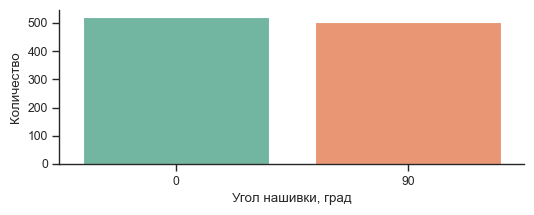

In [13]:
plt.figure(figsize=(6, 2))
sns.countplot(x='Угол нашивки, град', data=df, palette='Set2').set(ylabel = 'Количество')
plt.show()

## 3.4. Анализ количественных данных

### 3.4.1. Описательная статистика

In [16]:
# описательная статистика признаков 
df.describe(include='all').round(3).T

count      mean      std       min  \
Соотношение матрица-наполнитель       1023.0     2.930    0.913     0.389   
Плотность, кг/м3                      1023.0  1975.735   73.729  1731.765   
Модуль упругости, ГПа                 1023.0   739.923  330.232     2.437   
Количество отвердителя, м.%           1023.0   110.571   28.296    17.740   
Содержание эпоксидных групп, %_2      1023.0    22.244    2.406    14.255   
Температура вспышки, С_2              1023.0   285.882   40.943   100.000   
Поверхностная плотность, г/м2         1023.0   482.732  281.315     0.604   
Модуль упругости при растяжении, ГПа  1023.0    73.329    3.119    64.054   
Прочность при растяжении, МПа         1023.0  2466.923  485.628  1036.857   
Потребление смолы, г/м2               1023.0   218.423   59.736    33.803   
Угол нашивки, град                    1023.0    44.252   45.016     0.000   
Шаг нашивки                           1023.0     6.899    2.563     0.000   
Плотность нашивки                     1023.0    57.154   12.351     0.000   

                                           25%       50%       75%       max  
Соотношение матрица-наполнитель          2.318     2.907     3.553     5.592  
Плотность, кг/м3                      1924.155  1977.622  2021.374  2207.773  
Модуль упругости, ГПа                  500.047   739.664   961.813  1911.536  
Количество отвердителя, м.%             92.443   110.565   129.730   198.953  
Содержание эпоксидных групп, %_2        20.608    22.231    23.962    33.000  
Температура вспышки, С_2               259.067   285.897   313.002   413.273  
Поверхностная плотность, г/м2          266.817   451.864   693.225  1399.542  
Модуль упругости при растяжении, ГПа    71.245    73.269    75.357    82.682  
Прочность при растяжении, МПа         2135.850  2459.525  2767.193  3848.437  
Потребление смолы, г/м2                179.628   219.199   257.482   414.591  
Угол нашивки, град                       0.000     0.000    90.000    90.000  
Шаг нашивки                              5.080     6.916     8.586    14.441  
Плотность нашивки                       49.799    57.342    64.945   103.989

### 3.4.2 Поиск и удаление аномалий

In [17]:
df = pd.read_excel('data/X_join.xlsx', index_col=0)
df.loc[
    (df[df.columns[11]] < 0) | (df[df.columns[11]] == 0) |
    (df[df.columns[12]] < 0) | (df[df.columns[12]] == 0)
].T

19
Соотношение матрица-наполнитель          3.532338
Плотность, кг/м3                      1980.000000
Модуль упругости, ГПа                 1183.000000
Количество отвердителя, м.%            111.860000
Содержание эпоксидных групп, %_2        22.267857
Температура вспышки, С_2               284.615385
Поверхностная плотность, г/м2         1010.000000
Модуль упругости при растяжении, ГПа    78.000000
Прочность при растяжении, МПа         2000.000000
Потребление смолы, г/м2                300.000000
Угол нашивки, град                       0.000000
Шаг нашивки                              0.000000
Плотность нашивки                        0.000000

In [18]:
# удаление аномалий
df = df.drop(index=19)
df.reset_index(drop=True, inplace=True)
df.to_excel('data/X_join_not_anomaly.xlsx')
df.describe().T

count         mean         std  \
Соотношение матрица-наполнитель       1022.0     2.929777    0.913475   
Плотность, кг/м3                      1022.0  1975.730715   73.765207   
Модуль упругости, ГПа                 1022.0   739.489694  330.101862   
Количество отвердителя, м.%           1022.0   110.569507   28.309736   
Содержание эпоксидных групп, %_2      1022.0    22.244367    2.407479   
Температура вспышки, С_2              1022.0   285.883391   40.963286   
Поверхностная плотность, г/м2         1022.0   482.215915  280.967801   
Модуль упругости при растяжении, ГПа  1022.0    73.324000    3.117080   
Прочность при растяжении, МПа         1022.0  2467.379714  485.645758   
Потребление смолы, г/м2               1022.0   218.343323   59.710570   
Угол нашивки, град                    1022.0    44.295499   45.016514   
Шаг нашивки                           1022.0     6.905973    2.555608   
Плотность нашивки                     1022.0    57.209853   12.226746   

                                              min          25%          50%  \
Соотношение матрица-наполнитель          0.389403     2.317247     2.906630   
Плотность, кг/м3                      1731.764635  1924.134147  1977.603973   
Модуль упругости, ГПа                    2.436909   499.321940   739.310747   
Количество отвердителя, м.%             17.740275    92.431413   110.549159   
Содержание эпоксидных групп, %_2        14.254985    20.607747    22.230545   
Температура вспышки, С_2               100.000000   259.029216   285.922290   
Поверхностная плотность, г/м2            0.603740   266.654559   451.588705   
Модуль упругости при растяжении, ГПа    64.054061    71.241213    73.266770   
Прочность при растяжении, МПа         1036.856605  2136.259145  2460.260972   
Потребление смолы, г/м2                 33.803026   179.604490   219.189018   
Угол нашивки, град                       0.000000     0.000000     0.000000   
Шаг нашивки                              0.037639     5.081732     6.922196   
Плотность нашивки                       11.740126    49.852483    57.362576   

                                              75%          max  
Соотношение матрица-наполнитель          3.552781     5.591742  
Плотность, кг/м3                      2021.384103  2207.773481  
Модуль упругости, ГПа                  960.465724  1911.536477  
Количество отвердителя, м.%            129.732521   198.953207  
Содержание эпоксидных групп, %_2        23.962050    33.000000  
Температура вспышки, С_2               313.012786   413.273418  
Поверхностная плотность, г/м2          692.342336  1399.542362  
Модуль упругости при растяжении, ГПа    75.338920    82.682051  
Прочность при растяжении, МПа         2768.016102  3848.436732  
Потребление смолы, г/м2                257.399329   414.590628  
Угол нашивки, град                      90.000000    90.000000  
Шаг нашивки                              8.586378    14.440522  
Плотность нашивки                       64.959026   103.988901

### 3.4.3. Оценка плотности распределения

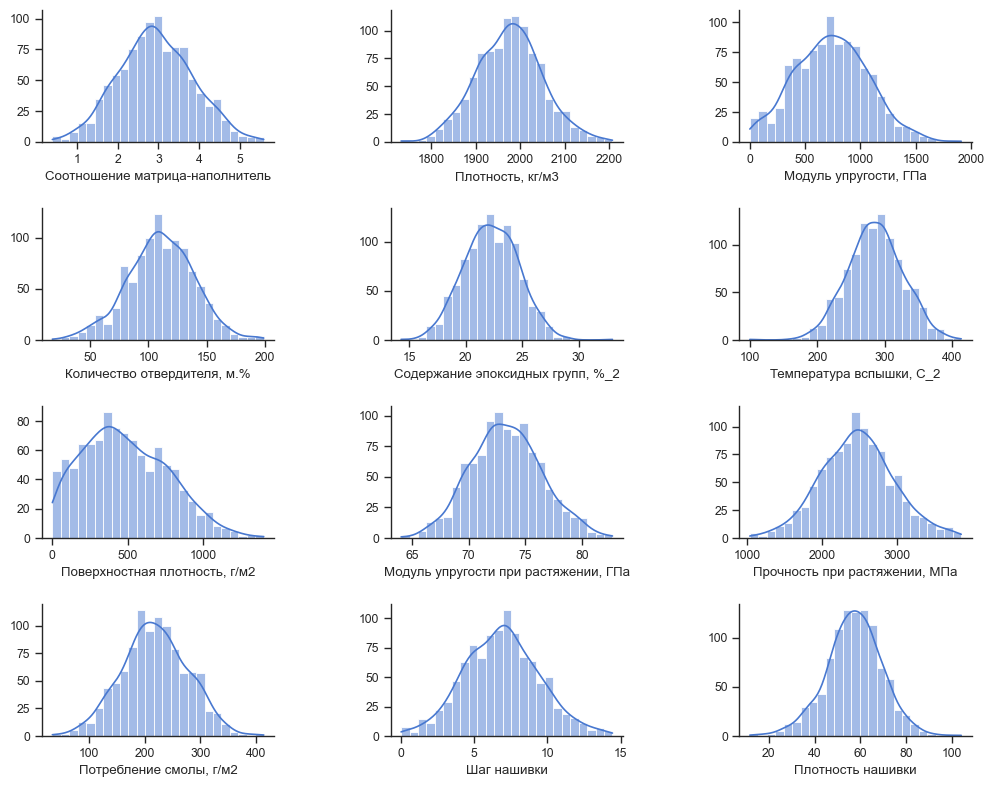

In [19]:
project_kde(12, 12, 3, df, [df.columns[10]])

### 3.4.4. Поиск выбросов

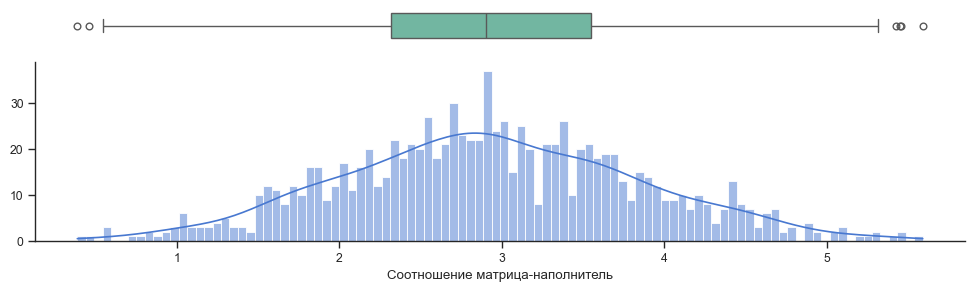

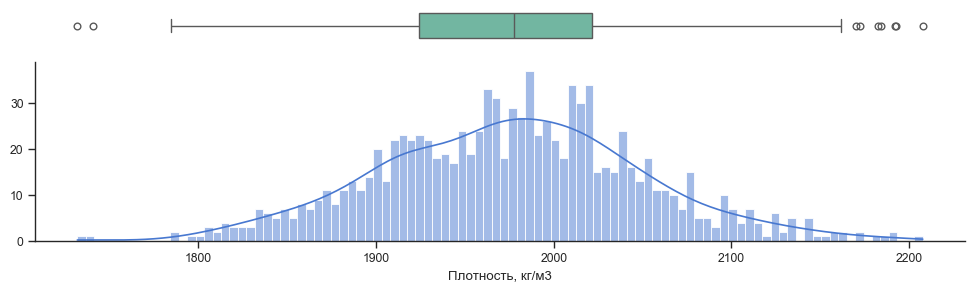

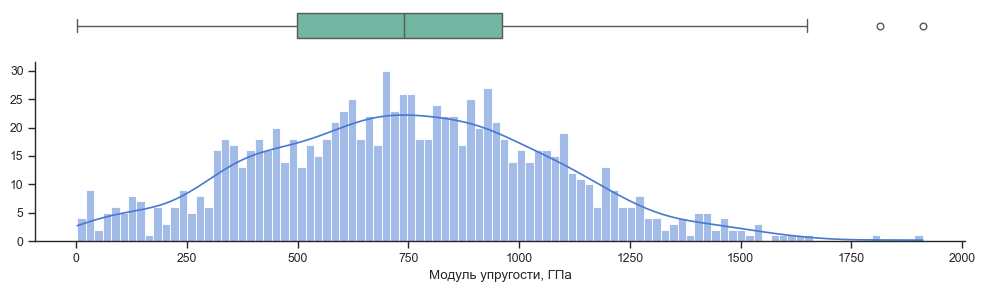

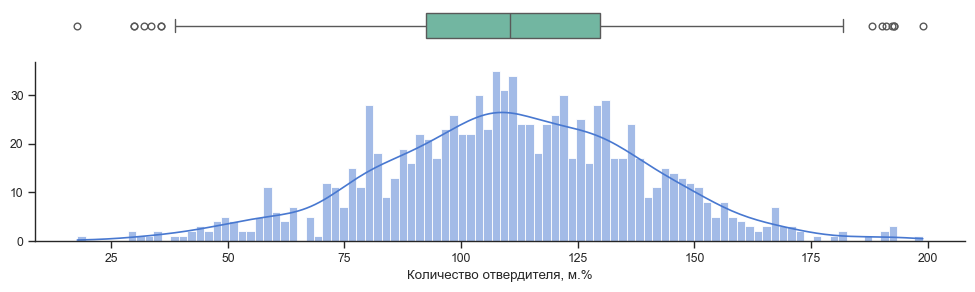

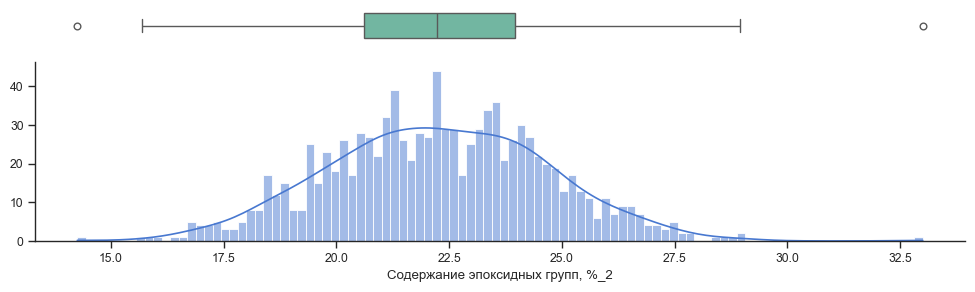

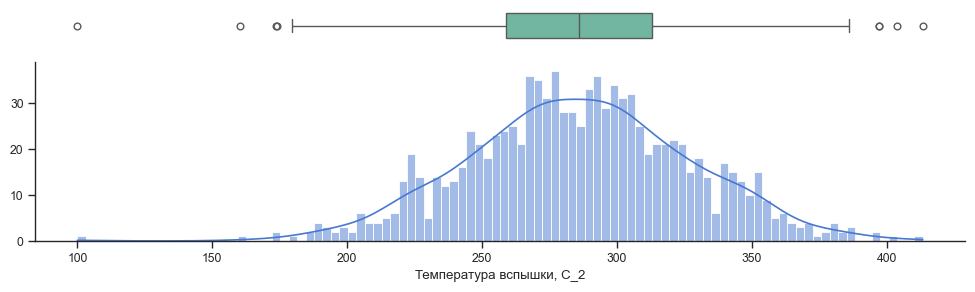

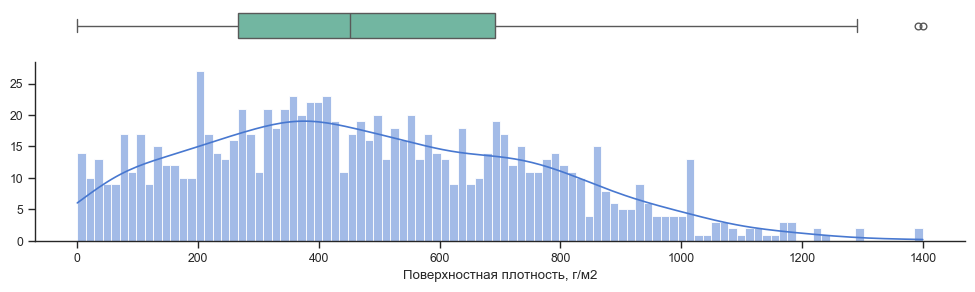

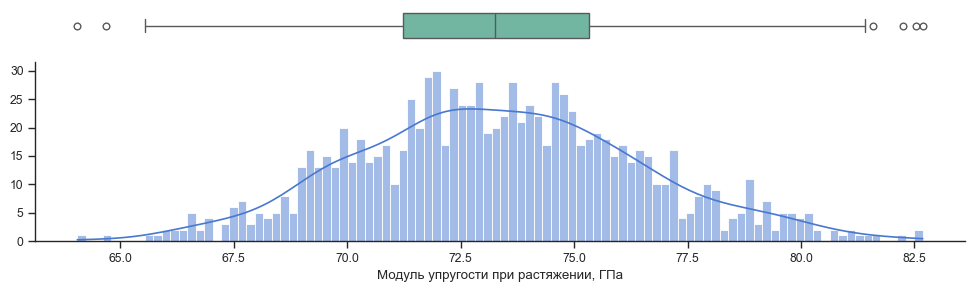

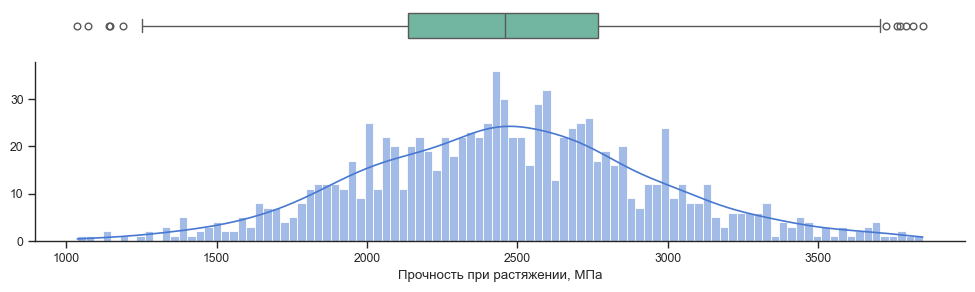

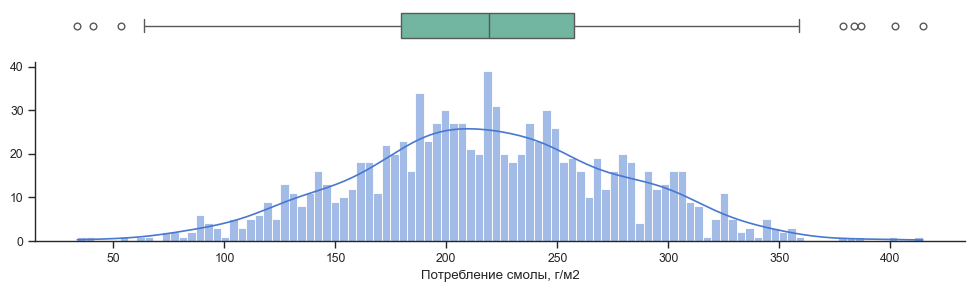

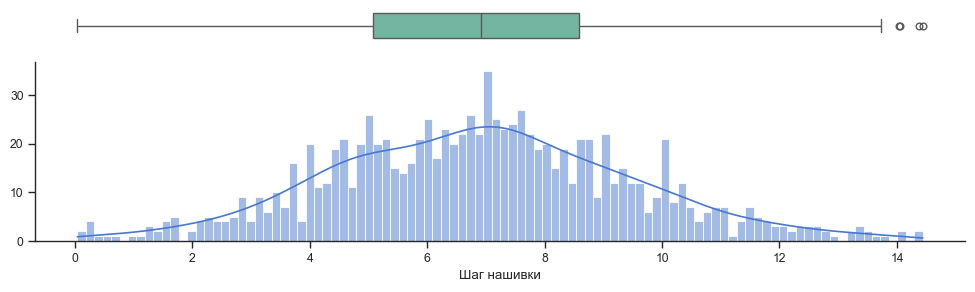

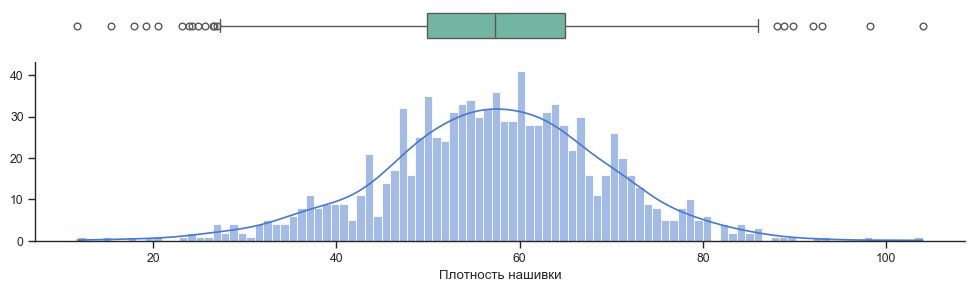

In [20]:
df = pd.read_excel('data/X_join_not_anomaly.xlsx', index_col=0)
for c in range(0, df.shape[1]):
    if df.columns[c] == 'Угол нашивки, град':
        continue;
    fig, (ax_box, ax_hist) = plt.subplots(
        2,                                            # две строки в сетке подграфиков
        sharex =False,                                # единая шкала по оси x и
        gridspec_kw ={'height_ratios': (.15, .85)},   # пропорция 15/85 по высоте
        figsize =(12, 3)
        #figsize =(3.5, 2)
    )
    sns.boxplot(data = df, x = df.columns[c], ax = ax_box, palette='Set2')
    sns.histplot(data = df, x = df.columns[c], ax = ax_hist, kde = True, bins=100)
    ax_box.set(xlabel = '', yticks=[], xticks=[])
    ax_hist.set(ylabel = '')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True, bottom=True)
    plt.savefig('image/' + str(c) + '.png', bbox_inches='tight')
    plt.savefig
    plt.show()
    print()
    print()

### 3.4.5. Взаимосвязь данных

In [21]:
# корреляционная матрица
df.corr().round(2)

Соотношение матрица-наполнитель  \
Соотношение матрица-наполнитель                                  1.00   
Плотность, кг/м3                                                 0.00   
Модуль упругости, ГПа                                            0.03   
Количество отвердителя, м.%                                     -0.01   
Содержание эпоксидных групп, %_2                                 0.02   
Температура вспышки, С_2                                        -0.00   
Поверхностная плотность, г/м2                                   -0.01   
Модуль упругости при растяжении, ГПа                            -0.01   
Прочность при растяжении, МПа                                    0.02   
Потребление смолы, г/м2                                          0.07   
Угол нашивки, град                                              -0.03   
Шаг нашивки                                                      0.04   
Плотность нашивки                                               -0.00   

                                      Плотность, кг/м3  Модуль упругости, ГПа  \
Соотношение матрица-наполнитель                   0.00                   0.03   
Плотность, кг/м3                                  1.00                  -0.01   
Модуль упругости, ГПа                            -0.01                   1.00   
Количество отвердителя, м.%                      -0.04                   0.02   
Содержание эпоксидных групп, %_2                 -0.01                  -0.01   
Температура вспышки, С_2                         -0.02                   0.03   
Поверхностная плотность, г/м2                     0.04                  -0.01   
Модуль упругости при растяжении, ГПа             -0.02                   0.02   
Прочность при растяжении, МПа                    -0.07                   0.04   
Потребление смолы, г/м2                          -0.02                   0.00   
Угол нашивки, град                               -0.07                  -0.02   
Шаг нашивки                                      -0.06                  -0.01   
Плотность нашивки                                 0.08                   0.06   

                                      Количество отвердителя, м.%  \
Соотношение матрица-наполнитель                             -0.01   
Плотность, кг/м3                                            -0.04   
Модуль упругости, ГПа                                        0.02   
Количество отвердителя, м.%                                  1.00   
Содержание эпоксидных групп, %_2                            -0.00   
Температура вспышки, С_2                                     0.10   
Поверхностная плотность, г/м2                                0.06   
Модуль упругости при растяжении, ГПа                        -0.07   
Прочность при растяжении, МПа                               -0.08   
Потребление смолы, г/м2                                      0.01   
Угол нашивки, град                                           0.04   
Шаг нашивки                                                  0.02   
Плотность нашивки                                            0.02   

                                      Содержание эпоксидных групп, %_2  \
Соотношение матрица-наполнитель                                   0.02   
Плотность, кг/м3                                                 -0.01   
Модуль упругости, ГПа                                            -0.01   
Количество отвердителя, м.%                                      -0.00   
Содержание эпоксидных групп, %_2                                  1.00   
Температура вспышки, С_2                                         -0.01   
Поверхностная плотность, г/м2                                    -0.01   
Модуль упругости при растяжении, ГПа                              0.06   
Прочность при растяжении, МПа                                    -0.02   
Потребление смолы, г/м2                                           0.02   
Угол нашивки, град                                                0.01   
Шаг нашивки              

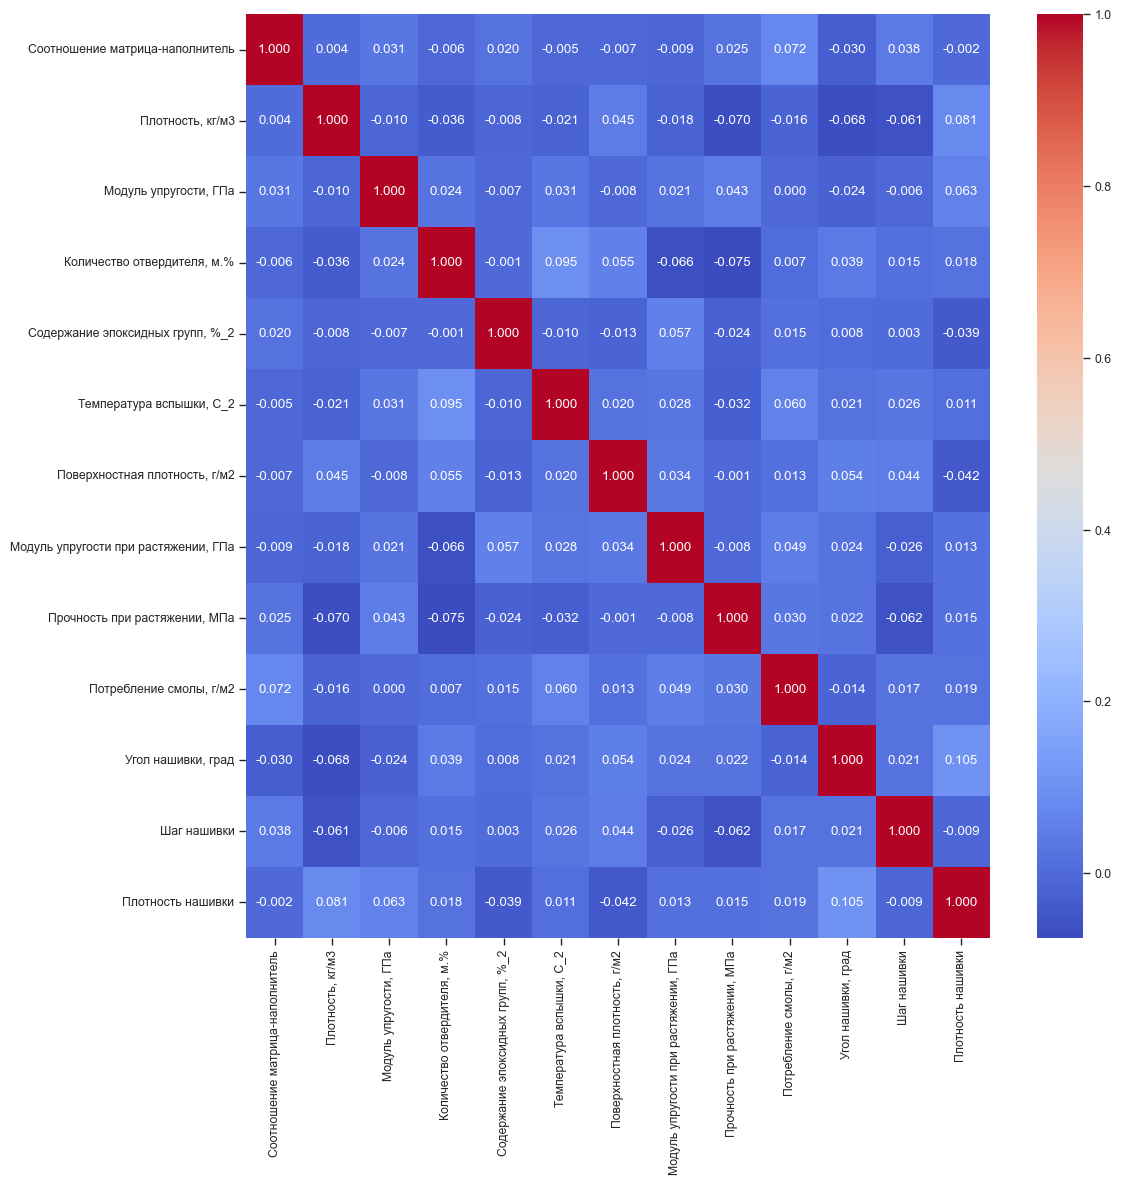

In [24]:
# тепловая карта матрицы корреляции
plt.figure(figsize = (12, 12))
sns.heatmap(df.corr(), cmap='coolwarm', fmt='0.3f', annot=True)
plt.show()

<Figure size 1200x1200 with 0 Axes>

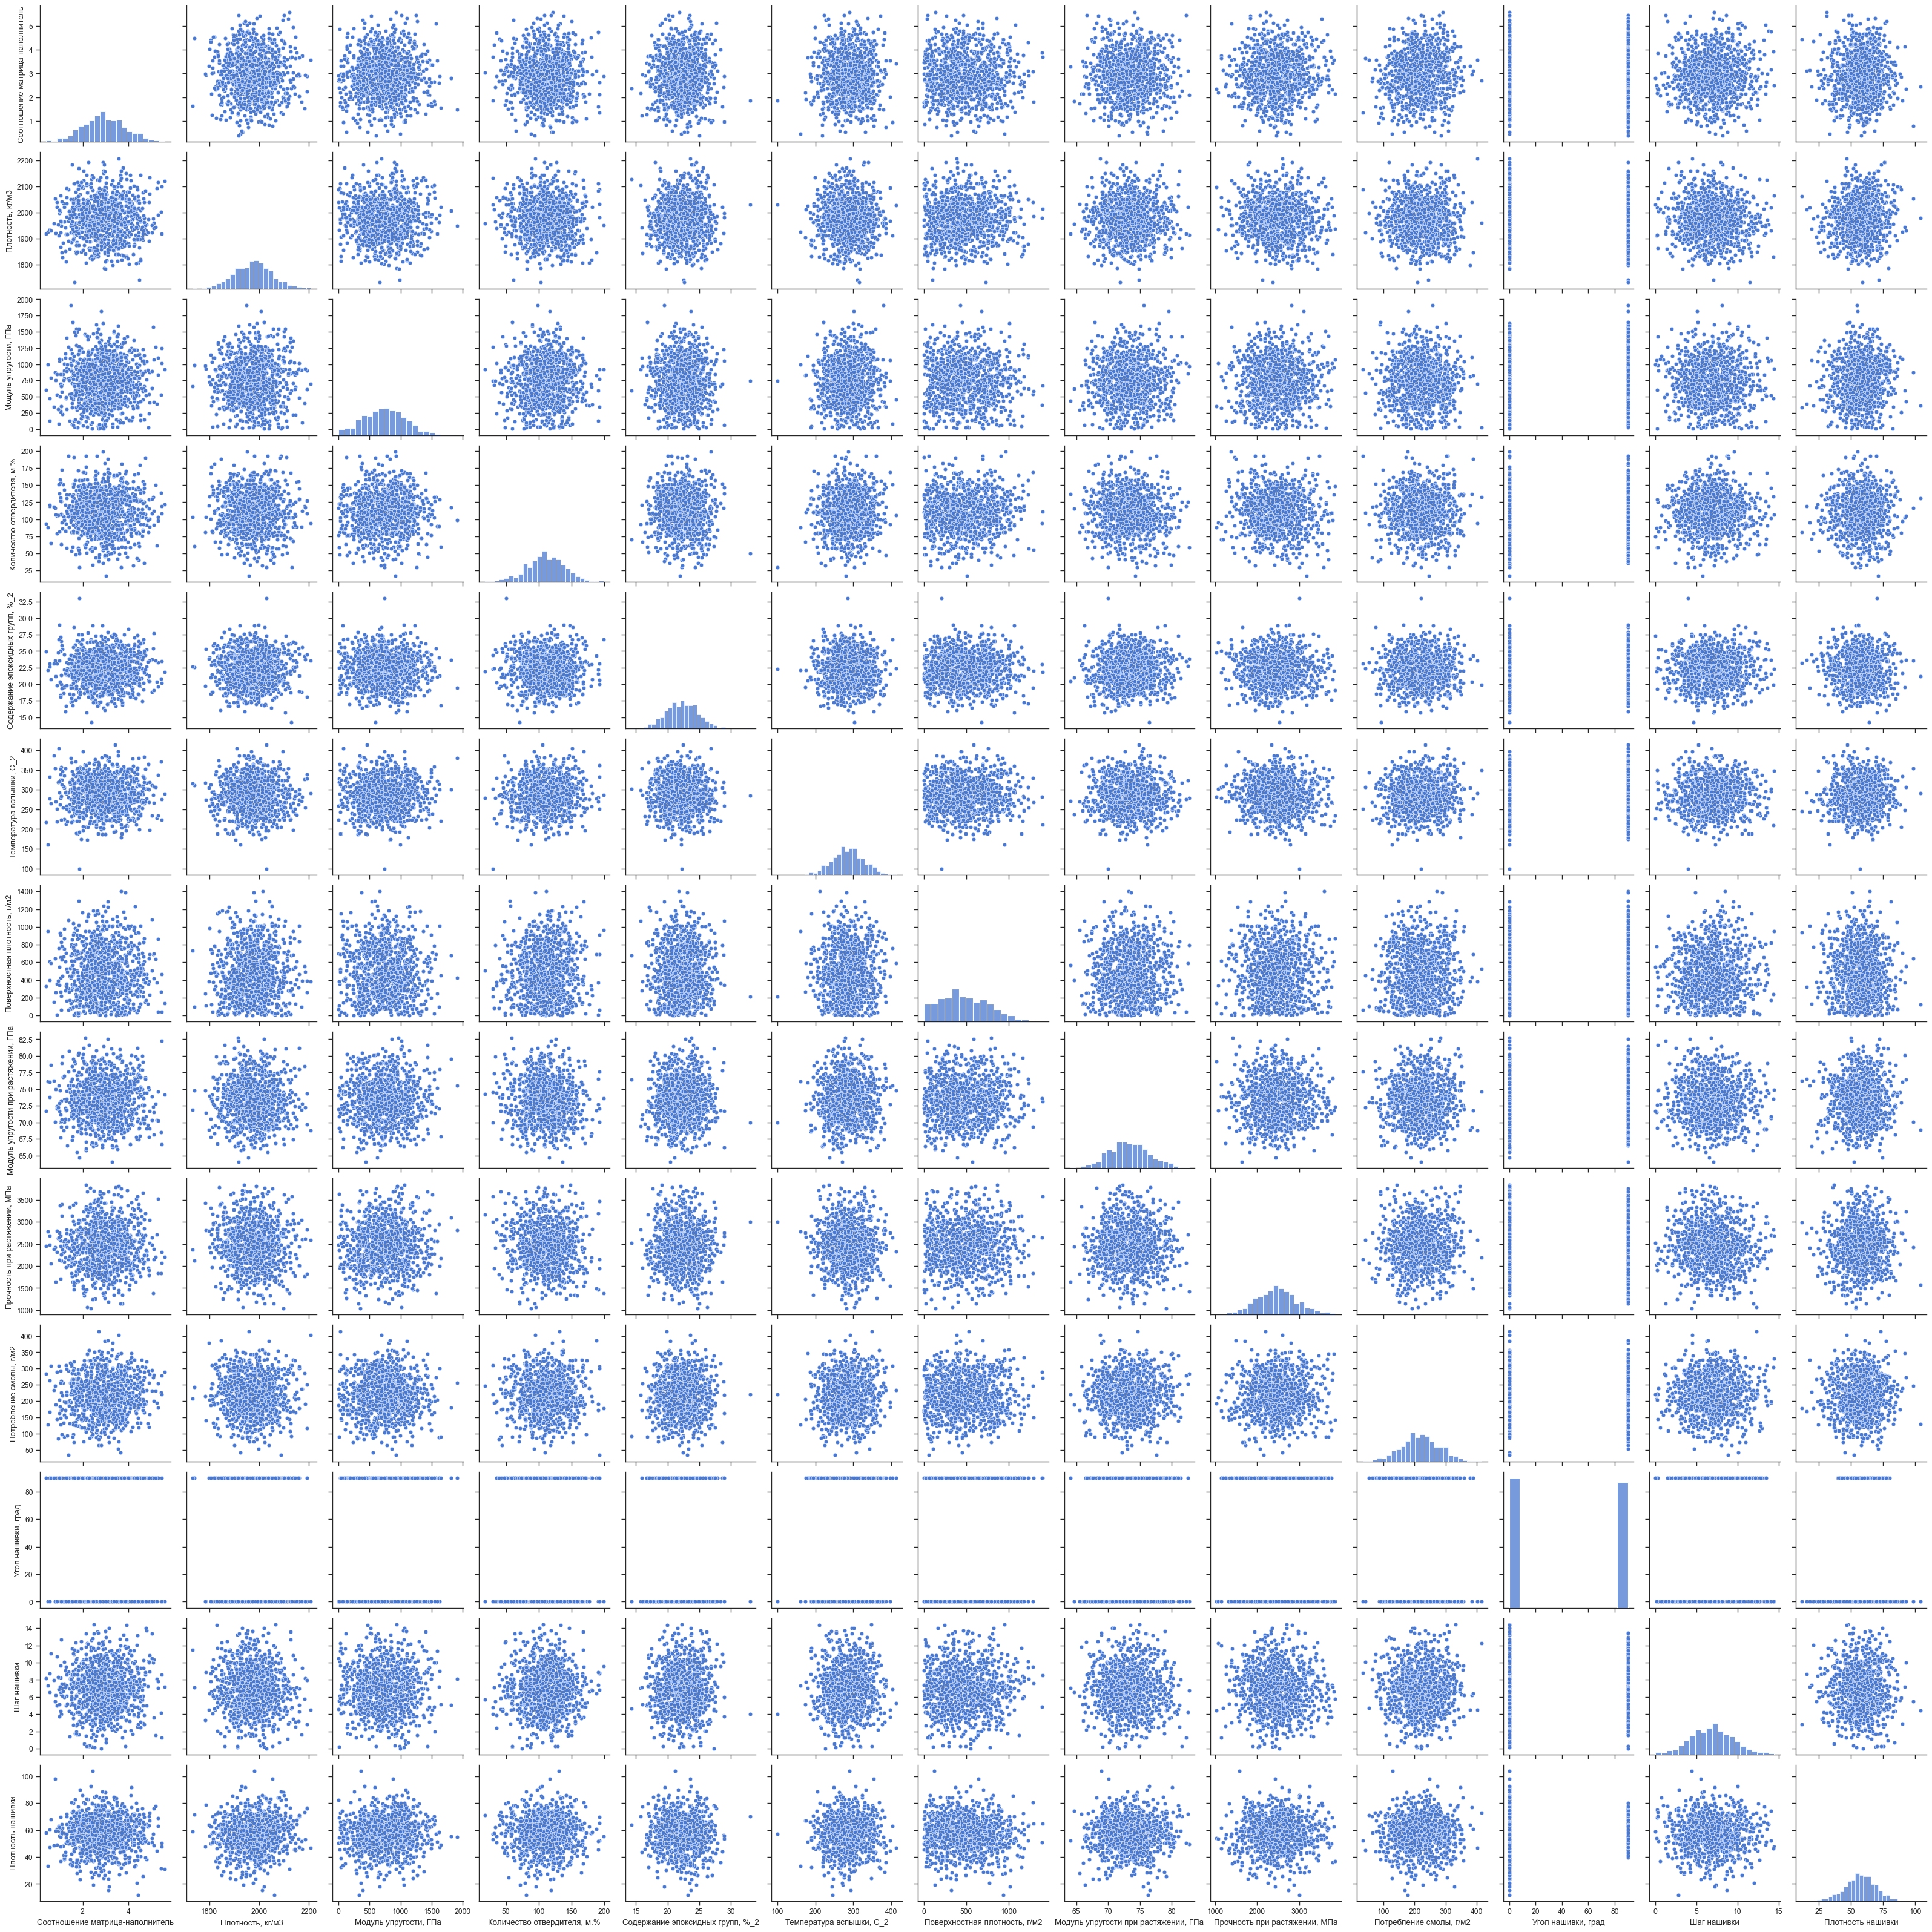

In [25]:
# графики попарного рассеивания точек
plt.figure(figsize = (12, 12))
sns.pairplot(df)
plt.show()

<Figure size 1200x1200 with 0 Axes>

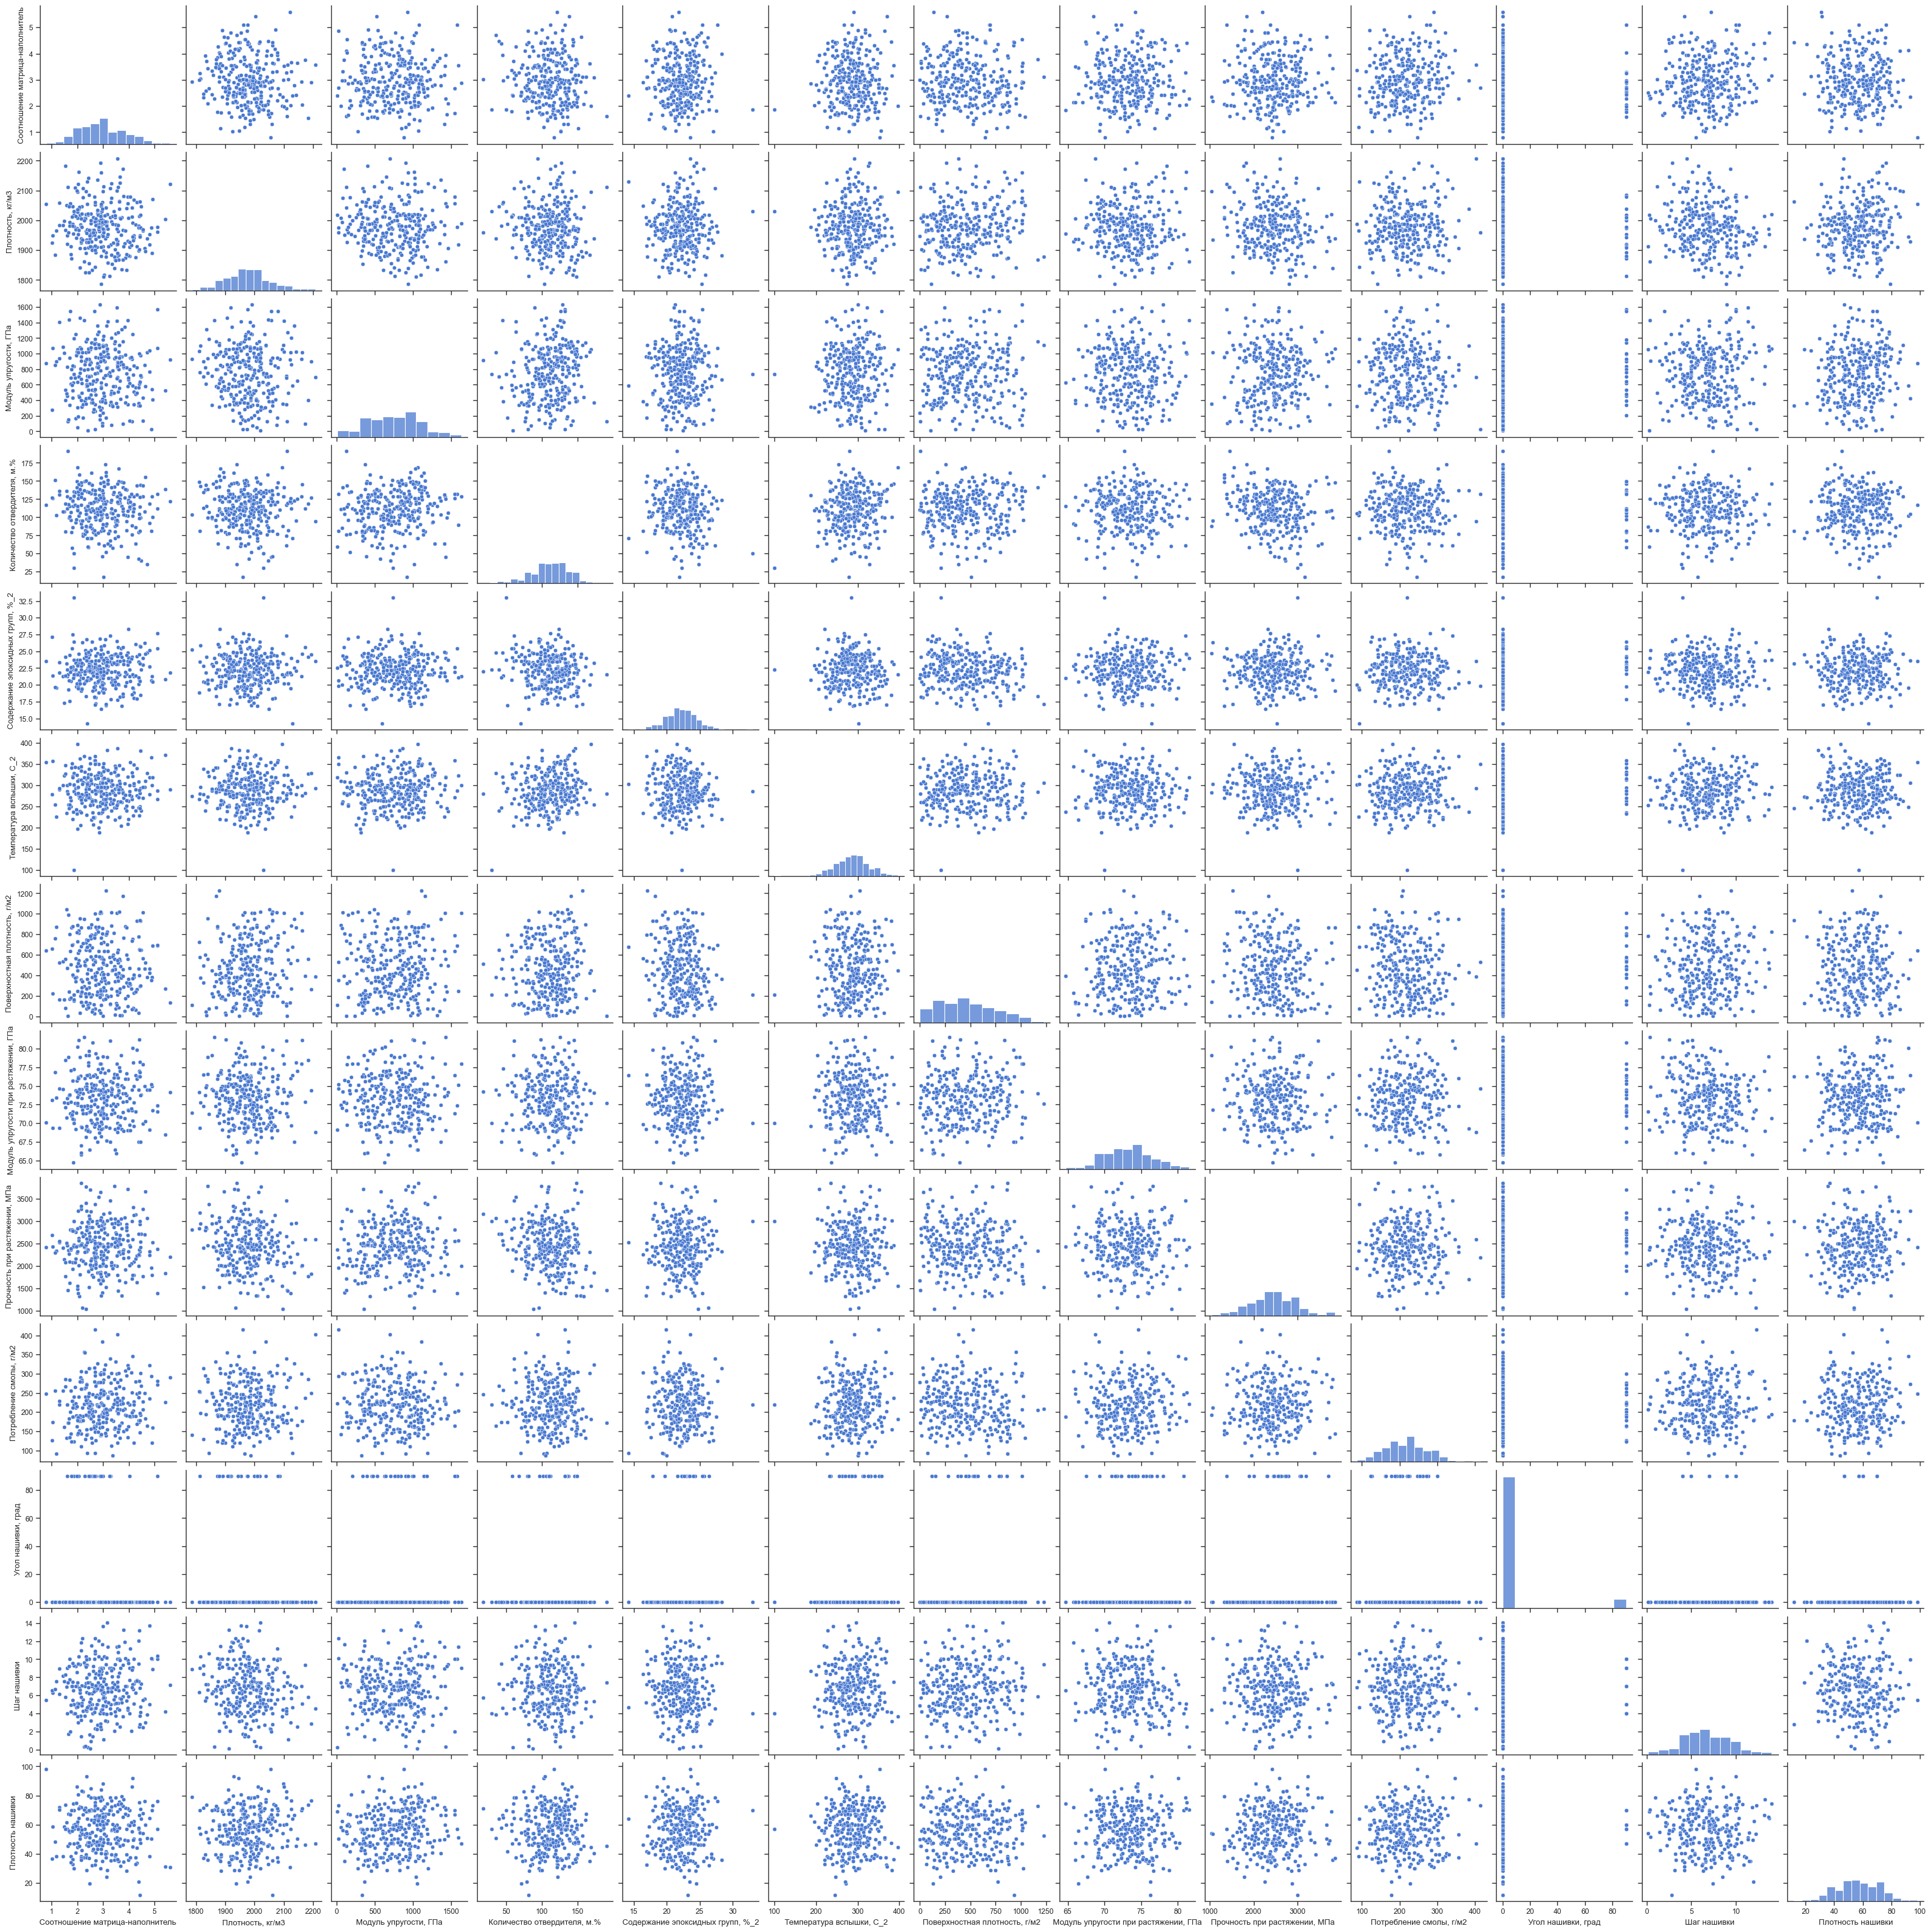

In [26]:
# графики попарного рассеивания точек из 300 первых записей
plt.figure(figsize = (12, 12))
sns.pairplot(df.head(300))
plt.show()

<Figure size 1200x800 with 0 Axes>

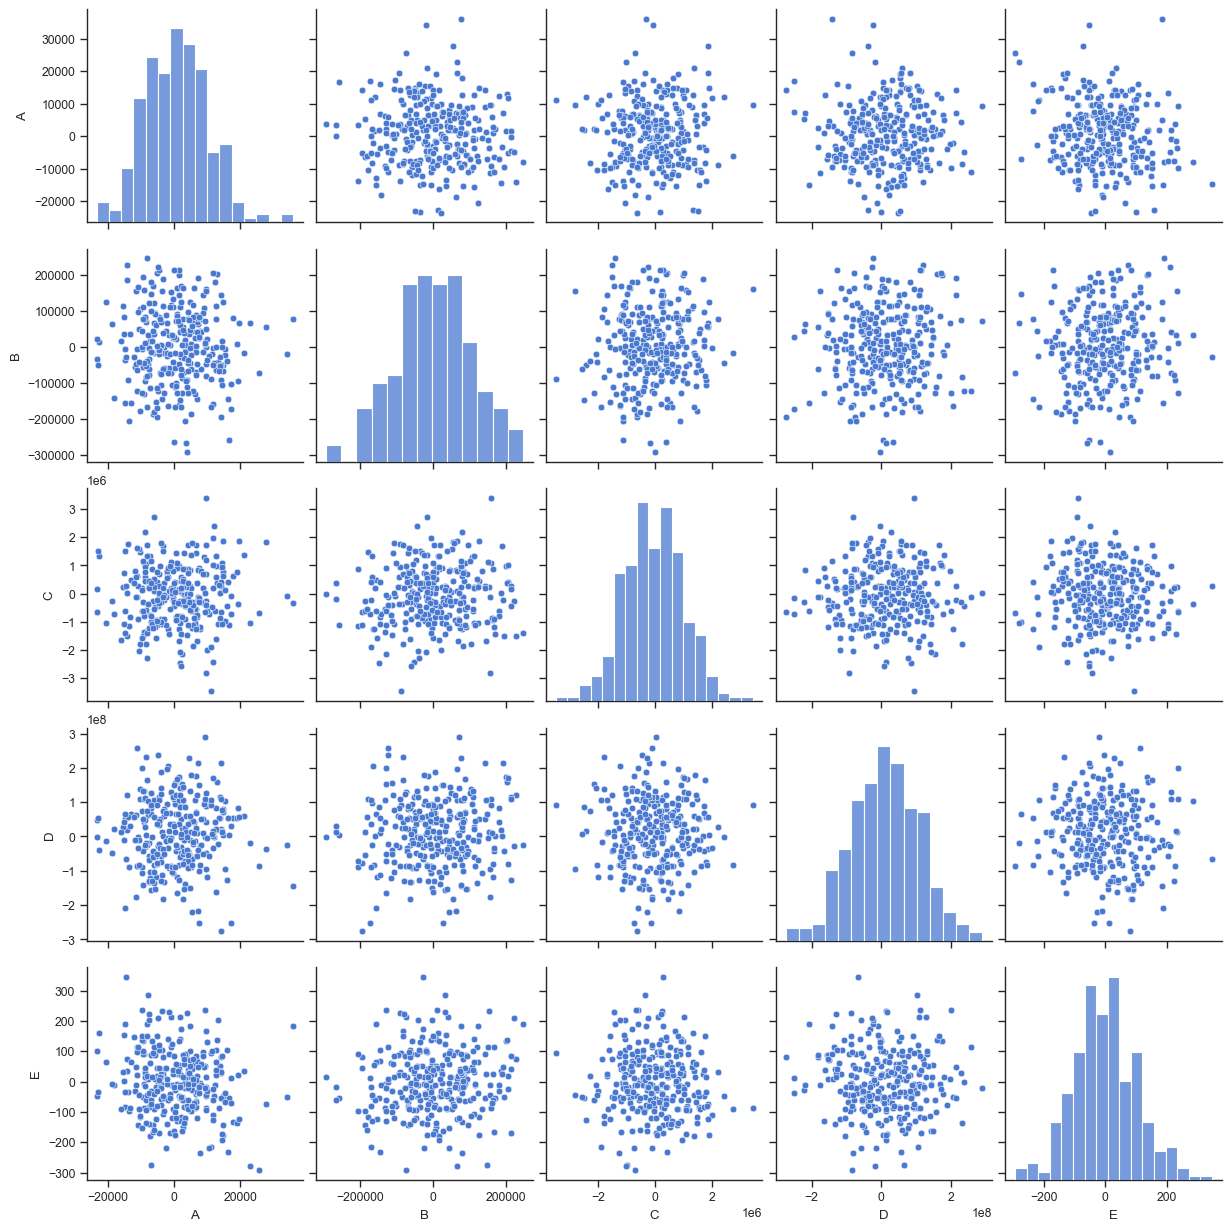

In [27]:
# создание экспериментального датасета и сгенерация данных по нормальному закону распределения
df_test = pd.DataFrame({
    'A': np.random.normal(0, 10_000, size=(300)),
    'B': np.random.normal(100, 100_000, size=(300)),
    'C': np.random.normal(10_000, 1_000_000, size=(300)),
    'D': np.random.normal(1_000_000, 100_000_000, size=(300)),
    'E': np.random.normal(0, 100, size=(300))
})
# графики попарного рассеивания точек экспериментального датасета
plt.figure(figsize = (12, 8))
sns.pairplot(df_test)
plt.show()

In [28]:
# корреляционная матрица экспериментального датасета
df_test.corr().round(2)

A     B     C     D     E
A  1.00 -0.04  0.02  0.01 -0.16
B -0.04  1.00  0.07  0.05  0.08
C  0.02  0.07  1.00  0.03 -0.05
D  0.01  0.05  0.03  1.00 -0.05
E -0.16  0.08 -0.05 -0.05  1.00

In [29]:
df.sample(7).T

326          390          581  \
Соотношение матрица-наполнитель          3.310900     1.067339     3.228435   
Плотность, кг/м3                      1975.617983  1964.288205  2019.043878   
Модуль упругости, ГПа                  309.292413   349.326632   573.815019   
Количество отвердителя, м.%            123.899945   107.288383    88.459308   
Содержание эпоксидных групп, %_2        24.000739    19.988544    20.583309   
Температура вспышки, С_2               361.265523   223.449061   276.711107   
Поверхностная плотность, г/м2          831.256244    62.735026   593.134892   
Модуль упругости при растяжении, ГПа    66.221234    73.269941    78.556224   
Прочность при растяжении, МПа         2168.302984  2269.070085  2227.447322   
Потребление смолы, г/м2                135.266582   226.838666   272.671714   
Угол нашивки, град                       0.000000     0.000000    90.000000   
Шаг нашивки                              6.720534     3.986859     9.315287   
Плотность нашивки                       62.012589    57.341920    57.960591   

                                              480          622          375  \
Соотношение матрица-наполнитель          2.926824     3.706842     4.620887   
Плотность, кг/м3                      1883.306258  1819.454181  2017.040094   
Модуль упругости, ГПа                 1197.280772   645.728833  1050.535971   
Количество отвердителя, м.%             97.575685   181.032809   114.644485   
Содержание эпоксидных групп, %_2        22.020977    23.034720    23.745495   
Температура вспышки, С_2               348.134494   257.559187   252.147541   
Поверхностная плотность, г/м2          315.667923   297.240823   701.842769   
Модуль упругости при растяжении, ГПа    69.775824    68.367966    80.018778   
Прочность при растяжении, МПа         2403.843424  2192.559018  2170.596710   
Потребление смолы, г/м2                127.854649   214.912174   232.531076   
Угол нашивки, град                       0.000000    90.000000     0.000000   
Шаг нашивки                              6.604875     6.829304     7.259911   
Плотность нашивки                       24.283523    58.165196    53.415599   

                                              586  
Соотношение матрица-наполнитель          3.521605  
Плотность, кг/м3                      1993.219156  
Модуль упругости, ГПа                  445.475813  
Количество отвердителя, м.%            129.442140  
Содержание эпоксидных групп, %_2        20.726427  
Температура вспышки, С_2               301.971866  
Поверхностная плотность, г/м2          399.815520  
Модуль упругости при растяжении, ГПа    68.708028  
Прочность при растяжении, МПа         2379.634946  
Потребление смолы, г/м2                209.654610  
Угол нашивки, град                      90.000000  
Шаг нашивки                              9.752380  
Плотность нашивки                       59.888382

# 4. Подготовка данных

## 4.1. Удаление выбросов (метод Z-оценки)

In [30]:
df = pd.read_excel('data/X_join_not_anomaly.xlsx', index_col=0)
z = stats.zscore(df)
print('Выбросов по Z-оценке:', len(df[(np.abs(z) > 3).any(axis = 1)]))

Выбросов по Z-оценке: 23


In [31]:
df[(np.abs(z) > 3).any(axis = 1)]

Соотношение матрица-наполнитель  Плотность, кг/м3  Модуль упругости, ГПа  \
0                           1.857143       2030.000000             738.736842   
2                           1.857143       2030.000000             738.736842   
40                          2.465205       1936.099137            1056.554985   
99                          3.565855       2207.773481             696.149163   
139                         0.790499       2054.123810             876.794802   
210                         2.696183       1959.779639              26.827000   
256                         3.027269       1959.011062             916.441601   
278                         4.434429       2061.918771             328.876626   
297                         2.385109       2129.059629             589.782966   
374                         2.106888       1914.089369             963.748397   
377                         0.463342       1925.610616             992.760436   
411                         2.885855       1951.714931             918.042452   
437                         3.121963       2011.351029             386.740062   
460                         3.150281       2018.730096             666.071055   
463                         2.440166       1980.132394             357.938256   
502                         1.367585       2088.013591             923.421474   
591                         1.487419       1949.031040            1911.536477   
691                         3.695486       2014.825483             667.332585   
717                         3.883264       1978.962659             372.566673   
769                         2.796648       2007.727318            1815.865170   
790                         3.426368       2028.026074             453.458891   
872                         4.484135       1740.657496             984.287951   
917                         1.651444       1731.764635             664.058923   

     Количество отвердителя, м.%  Содержание эпоксидных групп, %_2  \
0                      30.000000                         22.267857   
2                      49.900000                         33.000000   
40                     71.294058                         24.523381   
99                     94.187613                         23.562885   
139                   116.889391                         23.564969   
210                   132.031952                         19.868797   
256                    17.740275                         21.965568   
278                    81.071393                         23.213218   
297                    70.760954                         14.254985   
374                    58.710809                         23.813708   
377                    88.383137                         22.147630   
411                   198.953207                         26.811285   
437                   118.954187                         23.695821   
460                    95.431804                         19.436391   
463                   130.541848                         21.177094   
502                   192.705385                         23.119301   
591                    98.380762                         19.447283   
691                   110.860146                         21.797640   
717                    94.803958                         23.056813   
769                   117.162722                         23.688583   
790                   105.674852                         22.415611   
872                    61.105569                         22.552746   
917                   103.299034                         22.625733   

     Температура вспышки, С_2  Поверхностная плотность, г/м2  \
0                  100.000000                     210.000000   
2                  284.615385                     210.000000   
40                 271.975678                     129.077163   
99                 291.803991                     384.629393   
139                353.561943                     643.64766

In [32]:
z_mask = (np.abs(z) < 3).all(axis = 1)
df = df[z_mask]
df.reset_index(drop=True, inplace=True)
df.to_excel('data/X_join_for_model.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       999 non-null    float64
 1   Плотность, кг/м3                      999 non-null    float64
 2   Модуль упругости, ГПа                 999 non-null    float64
 3   Количество отвердителя, м.%           999 non-null    float64
 4   Содержание эпоксидных групп, %_2      999 non-null    float64
 5   Температура вспышки, С_2              999 non-null    float64
 6   Поверхностная плотность, г/м2         999 non-null    float64
 7   Модуль упругости при растяжении, ГПа  999 non-null    float64
 8   Прочность при растяжении, МПа         999 non-null    float64
 9   Потребление смолы, г/м2               999 non-null    float64
 10  Угол нашивки, град                    999 non-null    int64  
 11  Шаг нашивки        

## 4.2. Преобразование данных (не используется)

### 4.2.1. Линейное преобразование, масштабирование - стандартизация (не используется)

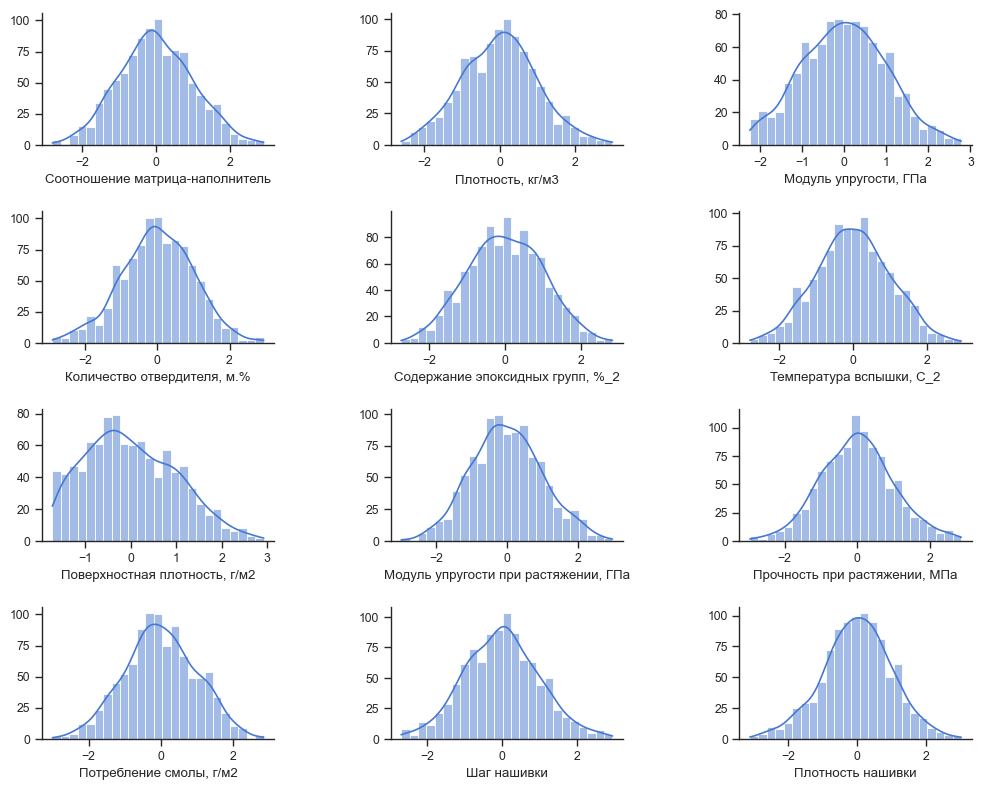

In [33]:
df_st = pd.DataFrame(StandardScaler().fit(df).transform(df), columns = df.columns)
project_kde(12, 12, 3, df_st, df.columns[10])

### 4.2.2. Линейное преобразование, масштабирование - нормализация (не используется)

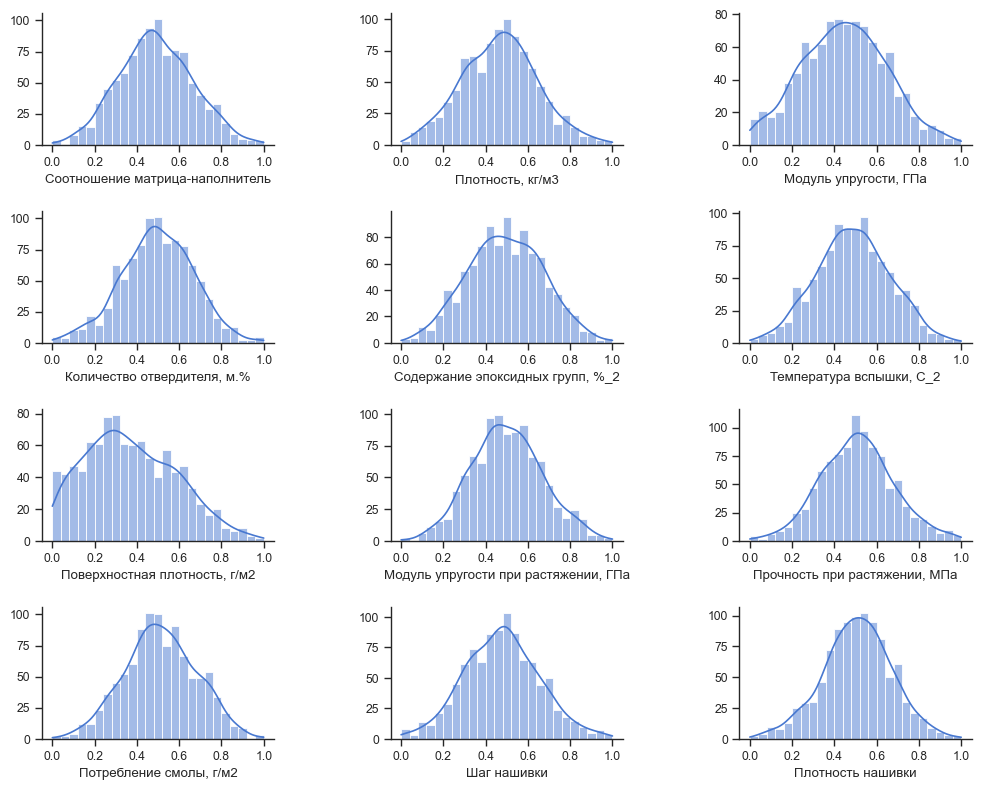

In [34]:
df_mm = pd.DataFrame(MinMaxScaler().fit(df).transform(df), columns = df.columns)
project_kde(12, 12, 3, df_mm, df.columns[10])

### 4.2.3. Нелинейное преобразование Йео-Джонсона (не используется)

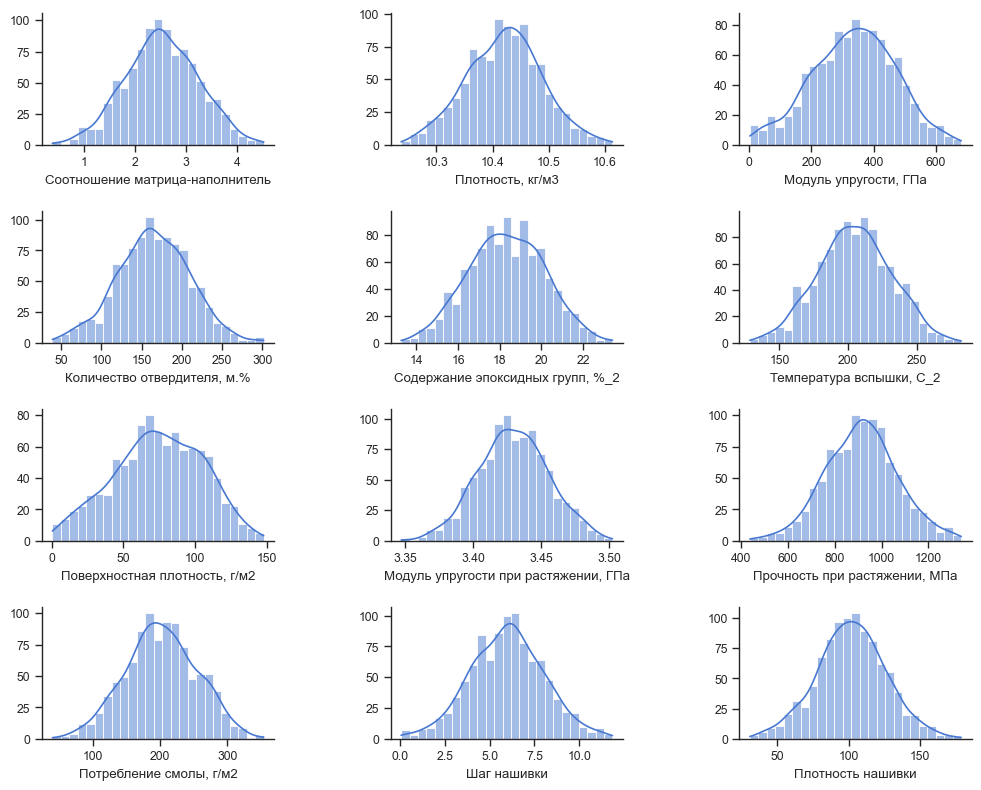

In [35]:
df_nl = pd.DataFrame(power_transform(df, method='yeo-johnson', standardize=False), columns = df.columns)
project_kde(12, 12, 3, df_nl, df.columns[10])

# 5. Построение модели

---
**Необходимо выполнить коды в:**<br>
**Пункт 1.** Подключение библиотек, конфигурирование<br>
**Пункт 3.4.3.** Оценка плотности распределения

---

## 5.1. Загрузка подготовленного для построения моделей датасета

In [37]:
df = pd.read_excel('data/X_join_for_model.xlsx', index_col=0)

## 5.2. Разделение датасета

### 5.2.1. Перечень признаков

In [38]:
pd.DataFrame(df.columns, columns=['Признак'])

Признак
0        Соотношение матрица-наполнитель
1                       Плотность, кг/м3
2                  Модуль упругости, ГПа
3            Количество отвердителя, м.%
4       Содержание эпоксидных групп, %_2
5               Температура вспышки, С_2
6          Поверхностная плотность, г/м2
7   Модуль упругости при растяжении, ГПа
8          Прочность при растяжении, МПа
9                Потребление смолы, г/м2
10                    Угол нашивки, град
11                           Шаг нашивки
12                     Плотность нашивки

### 5.2.2. Формирование выборок с факторами и целевыми признаками

#### Для ML-моделей

- Прогнозирование **Модуля упругости при растяжении**
- Прогнозирование **Прочности при растяжении**

In [39]:
# факторы количественные (числовые)
X_ml_label_dig = [
    df.columns[0],   # Соотношение матрица-наполнитель
    df.columns[1],   # Плотность, кг/м3
    df.columns[2],   # Модуль упругости, ГПа
    df.columns[3],   # Количество отвердителя, м.%
    df.columns[4],   # Содержание эпоксидных групп,%_2
    df.columns[9],   # Потребление смолы, г/м2
    df.columns[11],  # Шаг нашивки
    df.columns[12]   # Плотность нашивки
]
# факторы качественные (категориальные)
X_ml_label_cat = [
    df.columns[10]   # Угол нашивки, град
]
# выборка факторов
X_ml = df[X_ml_label_dig + X_ml_label_cat]

# целевые признаки
Y_ml_label = [
    df.columns[7],   # Модуль упругости при растяжении, ГПа
    df.columns[8]    # Прочность при растяжении, МПа
]
Y_ml = [
    df[[Y_ml_label[0]]],
    df[[Y_ml_label[1]]]
]

#### Для нейронной сети

- Рекомендация **Соотношения матрицы-наполнителя**

In [40]:
df = df.sort_values('Соотношение матрица-наполнитель')

# факторы количественные (числовые)
X_nn_label_dig = [
    df.columns[1],   # Плотность, кг/м3
    df.columns[2],   # Модуль упругости, ГПа
    df.columns[3],   # Количество отвердителя, м.%
    df.columns[4],   # Содержание эпоксидных групп,%_2
    df.columns[5],   # Температура вспышки, С_2
    df.columns[6],   # Поверхностная плотность, г/м2
    df.columns[7],   # Модуль упругости при растяжении, ГПа
    df.columns[8],   # Прочность при растяжении, МПа
    df.columns[9],   # Потребление смолы, г/м2
    df.columns[11],  # Шаг нашивки
    df.columns[12]   # Плотность нашивки
]
# факторы качественные (категориальные)
X_nn_label_cat = [
    df.columns[10]   # Угол нашивки, град
]
# выборка факторов
X_nn = df[X_nn_label_dig + X_nn_label_cat]

# целевой признак - Соотношение матрица-наполнитель
Y_nn_label = df.columns[0]
Y_nn = df[[Y_nn_label]]

### 5.2.3. Нормализация количественных признаков (пример)

In [41]:
df_dig = df.drop('Угол нашивки, град', axis=1)
df_dig.describe().T[['min', 'mean', 'max']]

min         mean          max
Соотношение матрица-наполнитель          0.389403     2.937129     5.591742
Плотность, кг/м3                      1784.482245  1975.463852  2192.738783
Модуль упругости, ГПа                    2.436909   738.450188  1649.415706
Количество отвердителя, м.%             29.956150   110.874067   192.851702
Содержание эпоксидных групп, %_2        15.695894    22.233969    28.955094
Температура вспышки, С_2               173.484920   285.964652   403.652861
Поверхностная плотность, г/м2            0.603740   479.541965  1291.340115
Модуль упругости при растяжении, ГПа    64.054061    73.308804    82.525773
Прочность при растяжении, МПа         1036.856605  2465.907130  3848.436732
Потребление смолы, г/м2                 41.048278   218.188960   386.903431
Шаг нашивки                              0.037639     6.910734    14.440522
Плотность нашивки                       20.571633    57.283879    92.963492

In [43]:
df_dig_st = pd.DataFrame(
    ColumnTransformer([
        ('scaler', MinMaxScaler(), df_dig.columns)
    ]).fit_transform(df_dig),
    columns = df_dig.columns
)
df_dig_st.describe().T[['min', 'mean', 'max']]

min      mean  max
Соотношение матрица-наполнитель       0.0  0.489727  1.0
Плотность, кг/м3                      0.0  0.467798  1.0
Модуль упругости, ГПа                 0.0  0.446887  1.0
Количество отвердителя, м.%           0.0  0.496747  1.0
Содержание эпоксидных групп, %_2      0.0  0.493097  1.0
Температура вспышки, С_2              0.0  0.488685  1.0
Поверхностная плотность, г/м2         0.0  0.371058  1.0
Модуль упругости при растяжении, ГПа  0.0  0.501023  1.0
Прочность при растяжении, МПа         0.0  0.508273  1.0
Потребление смолы, г/м2               0.0  0.512182  1.0
Шаг нашивки                           0.0  0.477203  1.0
Плотность нашивки                     0.0  0.507132  1.0

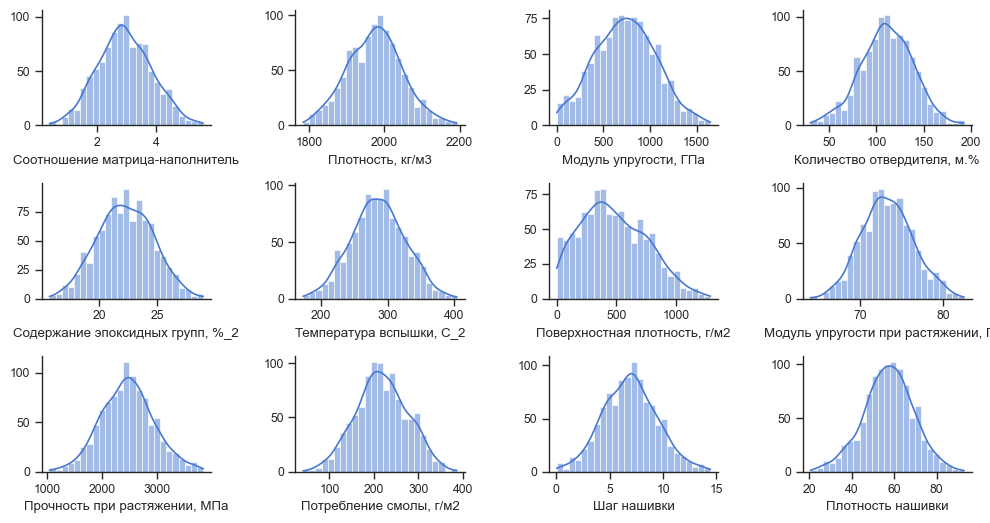

In [44]:
project_kde(12, 6, 4, df_dig)

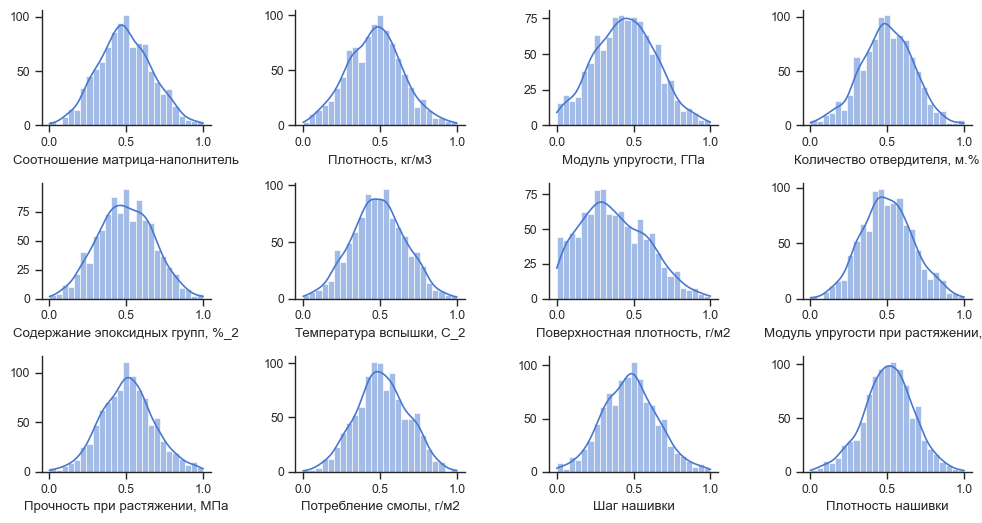

In [45]:
project_kde(12, 6, 4, df_dig_st)

### 5.2.4. Разделение факторов и целевых признаков на обучающую и тестовую выборки

#### Для ML-моделей

In [46]:
test_ml = train_test_split(X_ml, Y_ml[0], Y_ml[1], test_size=0.3, random_state=0)
test_ml = list(map(lambda x: x.sort_index().reset_index(drop=True), test_ml))

# обучающая выборка
X_ml_train = test_ml[0]
Y_ml_train = [
    test_ml[2],   # Модуль упругости при растяжении, ГПа
    test_ml[4]    # Прочность при растяжении, МПа
]

# тестовая выборка
X_ml_test = test_ml[1]
Y_ml_test = [
    test_ml[3],   # Модуль упругости при растяжении, ГПа
    test_ml[5]    # Прочность при растяжении, МПа
]

#### Для нейронной сети

In [47]:
test_nn = train_test_split(X_nn, Y_nn, test_size=0.3, random_state=0)
test_nn = list(map(lambda x: x.sort_index().reset_index(drop=True), test_nn))

# обучающая выборка
X_nn_train = test_nn[0]
Y_nn_train = test_nn[2]

# тестовая выборка
X_nn_test = test_nn[1]
Y_nn_test = test_nn[3]

## 5.3. Механизм обучения модели с кросс-валидацией, подбора гиперпараметров и сбора статистики по результатам (метрик и гиперпараметров)

### 5.3.1. Генерация структуры данных для хранения результатов обучения

In [55]:
def project_ml_create_struct():
    stat = pd.DataFrame({
        'MAE': [],         # средняя абсолютная ошибка
        'MSE': [],         # средняя квадратичная ошибка
        'RMSE': [],        # корень из средней квадратичной ошибки
        'MAPE': [],        # средняя абсолютная процентная ошибка
        'MAX ERROR': [],   # максимальная ошибка (главный критерий)
        'R^2': [],         # коэффициент детерминации
        'PARAM': []        # параметры модели
    })
    
    return stat.columns, [{
        'name': Y_ml_label[i],
        'def':{
            'fit': {},
            'stat_train': stat.copy(),
            'stat_test': stat.copy()
        },
        'prm': {
            'fit': {},
            'stat_train': stat.copy(),
            'stat_test': stat.copy()
        }
    } for i in range(len(Y_ml_label))]


mod_ml_stat_columns, mod_ml = project_ml_create_struct()

### 5.3.2. Функции

In [57]:
# функция формирования статистики по обучению
def project_ml_stat(mod, y_index):
    type_stat = {
        'stat_train': {'X': X_ml_train, 'Y': Y_ml_train[y_index]},
        'stat_test': {'X': X_ml_test, 'Y': Y_ml_test[y_index]}
    }
    for model in mod['fit']:
        for e in type_stat:
            predict = mod['fit'][model].predict(type_stat[e]['X'])
            if model not in mod[e].index: mod[e].index.append(pd.Index([model]))
            mod[e].loc[model] = [
                -metrics.mean_absolute_error(type_stat[e]['Y'], predict),
                -metrics.mean_squared_error(type_stat[e]['Y'], predict),
                -pow(metrics.mean_squared_error(type_stat[e]['Y'], predict), 0.5),
                -metrics.mean_absolute_percentage_error(type_stat[e]['Y'], predict),
                -metrics.max_error(type_stat[e]['Y'], predict),
                metrics.r2_score(type_stat[e]['Y'], predict),
                mod['fit'][model].best_params_
            ]

In [58]:
# функция определения имени модели
def project_ml_name_model(mod, metric,):
    return mod[mod[metric] == mod[metric].max()].index[0]

In [59]:
# функция визуализации качества модели
def project_ml_plot(models, name, X, Y, Y_label):
    plt.figure(figsize=(12, 4))
    plt.plot(Y, color='#DDDDDD', label='Данные', linewidth=2)
    plt.plot(models['Dummy'].predict(X), color='#555555', label='Dummy (базовая)')
    plt.plot(models[name].predict(X), color='#4682B4', label=name)
    plt.legend(loc='best')
    plt.title(name + ' : ' + Y_label)
    #plt.ylim([2400, 2600])
    plt.show()

In [60]:
# функция обучения модели
def project_ml_fit(model, X, Y, param = {}):
    return GridSearchCV(
        estimator=Pipeline([
            ('Transform', ColumnTransformer([
                ('scaler', MinMaxScaler(), X_ml_label_dig),
                ('category', OneHotEncoder(), X_ml_label_cat)
            ])),
            ('Model', model)
        ]),
        param_grid=param,
        cv=ShuffleSplit(
            n_splits=10,
            random_state=0
        ),
        scoring=metrics.make_scorer(
            metrics.mean_squared_error,
            greater_is_better=False
        ),
        n_jobs=-1,
        #refit=False
    ).fit(X, Y)

### 5.3.3. Конфикурация моделей и гиперпараметров

In [61]:
# функция управления подбором (обучением) моделей
def projest_ml_fit_run(y_index, cross_param = False):

    models_learn = {
        'Dummy': {
            'model': DummyRegressor(),
            'param': [{},{}],
            'learn': True
        },
        'Linear': {
            'model': LinearRegression(),
            'param': [{
                # Модуль упругости при растяжении, ГПа
                'Model__fit_intercept': [True, False],
                'Model__positive': [True, False]
            },{
                # Прочность при растяжении, МПа
                'Model__fit_intercept': [True, False],
                'Model__positive': [True, False]
            }],
            'learn': True
        },
        'Lasso': {
            'model': Lasso(),
            'param': [{
                # Модуль упругости при растяжении, ГПа
                'Model__fit_intercept': [True, False],
                'Model__positive': [True, False],
                'Model__precompute': [True, False],
                'Model__warm_start': [True, False],
                'Model__alpha': [0.1, 1, 10],
                'Model__tol': [0.00000001, 0.0000001, 0.000001],
                'Model__selection': ['cyclic', 'random']
            },{
                # Прочность при растяжении, МПа
                'Model__fit_intercept': [True, False],
                'Model__positive': [True, False],
                'Model__precompute': [True, False],
                'Model__warm_start': [True, False],
                'Model__alpha': [0.1, 0.2, 0.5],
                'Model__tol': [1, 5, 10, 15, 20],
                'Model__selection': ['cyclic', 'random']
            }],
            'learn': True
        },
        'Ridge': {
            'model': Ridge(),
            'param': [{
                # Модуль упругости при растяжении, ГПа
                'Model__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
                'Model__fit_intercept': [True, False],
                'Model__positive': [True, False],
                'Model__alpha': [0.00000001, 0.0000001, 0.000001],
                'Model__tol': [0.1, 1, 5]
            },{
                # Прочность при растяжении, МПа
                'Model__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
                'Model__fit_intercept': [True, False],
                'Model__positive': [True, False],
                'Model__alpha': [0.01, 0.1, 1, 5, 10],
                'Model__tol': [0.0001, 0.001, 0.01, 0.1, 1]
            }],
            'learn': True
        },
        'SVR': {
            'model': SVR(),
            'param': [{
                # Модуль упругости при растяжении, ГПа
                'Model__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                'Model__degree': [1, 2],
                'Model__C': [0.0000001, 0.000001, 0.00001],
                'Model__epsilon': [0.000001, 0.00001, 0.0001],
                'Model__tol': [10, 20, 30]
            },{
                # Прочность при растяжении, МПа
                'Model__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                'Model__degree': [1, 2],
                'Model__C': [14, 15, 16],
                'Model__epsilon': [0.01, 0.1, 1],
                'Model__tol': [1.5, 2, 5]
            }],
            'learn': True
        },
        'KNeighbors': {
            'model': KNeighborsRegressor(),
            'param': [{
                # Модуль упругости при растяжении, ГПа
                'Model__n_neighbors': [200],
                'Model__weights': ['uniform', 'distance'],
                'Model__leaf_size': [1],
                'Model__p': [1],
                'Model__metric': [
                    'braycurtis', 'canberra', 'chebyshev', 'cityblock',
                    'correlation', 'cosine', 'euclidean', 'jensenshannon',
                    'mahalanobis', 'minkowski', 'seuclidean', 'sqeuclidean',
                    'dice', 'hamming', 'jaccard', 'kulczynski1', 'rogerstanimoto',
                    'russellrao', 'sokalmichener', 'sokalsneath', 'yule'
               ]
            },{
                # Прочность при растяжении, МПа
                'Model__n_neighbors': [270],
                'Model__weights': ['uniform', 'distance'],
                'Model__leaf_size': [1],
                'Model__p': [1],
                'Model__metric': [
                    'braycurtis', 'canberra', 'chebyshev', 'cityblock',
                    'correlation', 'cosine', 'euclidean', 'jensenshannon',
                    'mahalanobis', 'minkowski', 'seuclidean', 'sqeuclidean',
                    'dice', 'hamming', 'jaccard', 'kulczynski1', 'rogerstanimoto',
                    'russellrao', 'sokalmichener', 'sokalsneath', 'yule'
               ]
            }],
            'learn': True
        },
        'DecisionTree': {
            'model': DecisionTreeRegressor(),
            'param': [{
                # Модуль упругости при растяжении, ГПа
                'Model__criterion': ['squared_error'],
                'Model__max_features': ['sqrt'],
                'Model__splitter': ['best', 'random'],
                'Model__ccp_alpha': [0.0],
                'Model__max_depth': [1]
            },{
                # Прочность при растяжении, МПа
                'Model__criterion': ['squared_error'],
                'Model__max_features': ['sqrt', 'log2'],
                'Model__splitter': ['best', 'random'],
                'Model__ccp_alpha': [0.4, 0.5, 0.6],
                'Model__max_depth': [1, 2]
            }],
            'learn': True
        },
        'RandomForestRegressor': {
            'model': RandomForestRegressor(),
            'param': [{
                # Модуль упругости при растяжении, ГПа
                'Model__criterion': ['squared_error'],
                'Model__max_features': ['log2'],
                'Model__ccp_alpha': [0.6],
                'Model__max_depth': [3]
            },{
                # Прочность при растяжении, МПа
                'Model__criterion': ['friedman_mse'],
                'Model__max_features': ['sqrt'],
                'Model__ccp_alpha': [1.5],
                'Model__max_depth': [3]
            }],
            'learn': True
        },
        'GradientBoosting': {
            'model': GradientBoostingRegressor(),
            'param': [{
                # Модуль упругости при растяжении, ГПа
                'Model__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
                'Model__criterion': ['friedman_mse', 'squared_error'],
                'Model__n_estimators': [13],
                'Model__max_depth': [1],
                'Model__alpha': [0.8],
                'Model__ccp_alpha': [0.5]
            },{
                # Прочность при растяжении, МПа
                'Model__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
                'Model__criterion': ['friedman_mse', 'squared_error'],
                'Model__n_estimators': [13],
                'Model__max_depth': [1],
                'Model__alpha': [0.6],
                'Model__ccp_alpha': [0.0],
            }],
            'learn': True
        },
        'AdaBoost': {
            'model': AdaBoostRegressor(),
            'param': [{
                # Модуль упругости при растяжении, ГПа
                'Model__loss': ['linear', 'square', 'exponential'],
                'Model__n_estimators': [10],
                'Model__learning_rate': [0.6]
            },{
                # Прочность при растяжении, МПа
                'Model__loss': ['linear', 'square', 'exponential'],
                'Model__n_estimators': [10, 15, 20],
                'Model__learning_rate': [0.1, 0.2, 0.25]
            }],
            'learn': True
        }
    }

    max_len = max(len(x) for x in models_learn.keys())
    print('Model'.ljust(max_len + 3, ' '), 'min(MSE)')

    mod_type = 'prm' if cross_param else 'def'
    for m in models_learn:
        if not models_learn[m]['learn']: continue
        print(m.ljust(max_len + 3, ' '), end='')
        fit = project_ml_fit(
            models_learn[m]['model'],
            X_ml_train,
            Y_ml_train[y_index],
            models_learn[m]['param'][y_index] if cross_param else {}
        )
        mod_ml[y_index][mod_type]['fit'][m] = fit
        print(fit.best_score_)
        
    project_ml_stat(mod_ml[y_index][mod_type], y_index)

## 5.4. Модель: Модуль упругости при растяжении, ГПа

### 5.4.1. Подбор наилучшей модели с параметрами по умолчанию

In [62]:
# Модуль упругости при растяжении, ГПа
print(Y_ml_label[0])
print('═════════════════════════════════════════════')
projest_ml_fit_run(0)

Модуль упругости при растяжении, ГПа
═════════════════════════════════════════════
Model                    min(MSE)
Dummy                   -9.422550069063705
Linear                  -9.593261455298727
Lasso                   -9.422550069063705
Ridge                   -9.582984399304696
SVR                     -9.712743264000192
KNeighbors              -11.662737751812148
DecisionTree            -19.382652887874645
RandomForestRegressor   -10.244557403151271
GradientBoosting        -10.42868816902316
AdaBoost                -9.806292989133318


In [63]:
# вывод результата проверки моделей на учебных данных
mod_ml[0]['def']['stat_train'].loc[:, mod_ml_stat_columns!='PARAM']

MAE       MSE      RMSE      MAPE  MAX ERROR  \
Dummy                 -2.493600 -9.638281 -3.104558 -0.034121  -9.289590   
Linear                -2.477741 -9.503202 -3.082726 -0.033912  -8.922781   
Lasso                 -2.493600 -9.638281 -3.104558 -0.034121  -9.289590   
Ridge                 -2.477739 -9.503463 -3.082769 -0.033911  -8.937508   
SVR                   -2.338113 -8.908212 -2.984663 -0.032000  -8.856482   
KNeighbors            -2.184414 -7.584350 -2.753970 -0.029885  -8.650154   
DecisionTree          -0.000000 -0.000000 -0.000000 -0.000000  -0.000000   
RandomForestRegressor -0.939578 -1.422841 -1.192829 -0.012874  -3.762754   
GradientBoosting      -1.820458 -5.218161 -2.284329 -0.024898  -7.948394   
AdaBoost              -2.360310 -8.099988 -2.846048 -0.032264  -6.362887   

                            R^2  
Dummy                  0.000000  
Linear                 0.014015  
Lasso                  0.000000  
Ridge                  0.013988  
SVR                    0.075747  
KNeighbors             0.213101  
DecisionTree           1.000000  
RandomForestRegressor  0.852376  
GradientBoosting       0.458600  
AdaBoost               0.159602

In [64]:
# вывод результата проверки моделей на тестовых данных
mod_ml[0]['def']['stat_test'].loc[:, mod_ml_stat_columns!='PARAM']

MAE        MSE      RMSE      MAPE  MAX ERROR  \
Dummy                 -2.473748  -9.555011 -3.091118 -0.033550  -8.180943   
Linear                -2.466658  -9.442342 -3.072839 -0.033452  -8.373028   
Lasso                 -2.473748  -9.555011 -3.091118 -0.033550  -8.180943   
Ridge                 -2.466670  -9.442751 -3.072906 -0.033453  -8.359833   
SVR                   -2.497468  -9.689850 -3.112852 -0.033858  -8.682430   
KNeighbors            -2.737170 -11.498437 -3.390935 -0.037218  -8.785891   
DecisionTree          -3.611605 -21.691094 -4.657370 -0.048969 -15.580104   
RandomForestRegressor -2.531522 -10.099310 -3.177941 -0.034370  -9.313786   
GradientBoosting      -2.560177 -10.309419 -3.210828 -0.034741  -9.679199   
AdaBoost              -2.526367  -9.781743 -3.127578 -0.034227  -8.114538   

                            R^2  
Dummy                 -0.006158  
Linear                 0.005706  
Lasso                 -0.006158  
Ridge                  0.005663  
SVR                   -0.020357  
KNeighbors            -0.210804  
DecisionTree          -1.284107  
RandomForestRegressor -0.063474  
GradientBoosting      -0.085599  
AdaBoost              -0.030033

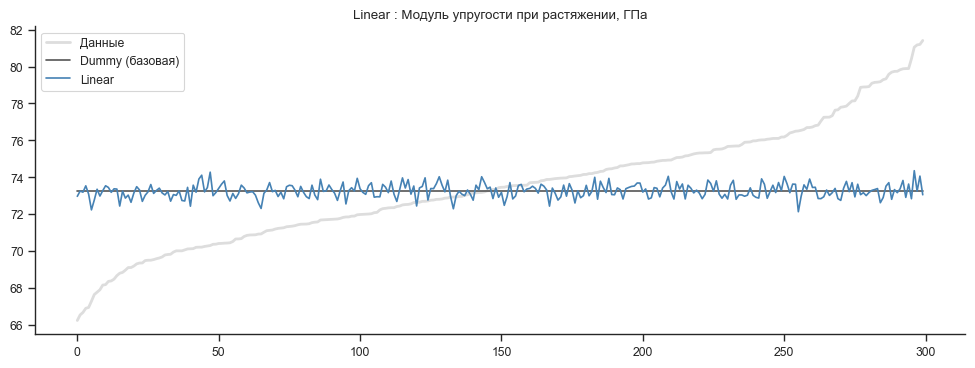

In [65]:
# визуализация качества лучшей модели на тестовых данных
X_ml_test_0, Y_ml_test_0 = X_ml_test, Y_ml_test[0]
X_ml_test_0, Y_ml_test_0 = project_sort_df(X_ml_test_0, Y_ml_test_0, 'Модуль упругости при растяжении, ГПа')
project_ml_plot(
    mod_ml[0]['def']['fit'],
    project_ml_name_model(mod_ml[0]['def']['stat_test'], 'MSE'),
    X_ml_test_0, Y_ml_test_0, Y_ml_label[0]
)

### 5.4.2. Подбор наилучшей модели с перебором гиперпараметров

In [66]:
# Модуль упругости при растяжении, ГПа
print(Y_ml_label[0])
print('═════════════════════════════════════════════')
projest_ml_fit_run(0, True)

Модуль упругости при растяжении, ГПа
═════════════════════════════════════════════
Model                    min(MSE)
Dummy                   -9.422550069063705
Linear                  -9.515275118825548
Lasso                   -9.422550069063705
Ridge                   -9.422550069063705
SVR                     -9.413854672884806
KNeighbors              -9.39962264161853
DecisionTree            -9.477348058190113
RandomForestRegressor   -9.422344709355126
GradientBoosting        -9.417789907997987
AdaBoost                -9.58835936690241


In [67]:
# вывод результата проверки моделей на учебных данных
mod_ml[0]['prm']['stat_train'].loc[:, mod_ml_stat_columns!='PARAM']

MAE       MSE      RMSE      MAPE  MAX ERROR  \
Dummy                 -2.493600 -9.638281 -3.104558 -0.034121  -9.289590   
Linear                -2.471696 -9.564170 -3.092599 -0.033828  -9.111710   
Lasso                 -2.493600 -9.638281 -3.104558 -0.034121  -9.289590   
Ridge                 -2.493600 -9.638281 -3.104558 -0.034121  -9.289590   
SVR                   -2.494718 -9.641168 -3.105023 -0.034161  -9.235856   
KNeighbors            -2.479222 -9.534128 -3.087738 -0.033933  -9.163844   
DecisionTree          -2.488899 -9.628665 -3.103009 -0.034054  -9.236198   
RandomForestRegressor -2.493745 -9.638355 -3.104570 -0.034127  -9.280943   
GradientBoosting      -2.492778 -9.642816 -3.105288 -0.034079  -9.356932   
AdaBoost              -2.423807 -8.949116 -2.991507 -0.033157  -8.853224   

                            R^2  
Dummy                  0.000000  
Linear                 0.007689  
Lasso                  0.000000  
Ridge                  0.000000  
SVR                   -0.000300  
KNeighbors             0.010806  
DecisionTree           0.000998  
RandomForestRegressor -0.000008  
GradientBoosting      -0.000471  
AdaBoost               0.071503

In [68]:
# вывод результата проверки моделей на тестовых данных
mod_ml[0]['prm']['stat_test'].loc[:, mod_ml_stat_columns!='PARAM']

MAE       MSE      RMSE      MAPE  MAX ERROR  \
Dummy                 -2.473748 -9.555011 -3.091118 -0.033550  -8.180943   
Linear                -2.465086 -9.510206 -3.083862 -0.033426  -8.454235   
Lasso                 -2.473748 -9.555011 -3.091118 -0.033550  -8.180943   
Ridge                 -2.473748 -9.555011 -3.091118 -0.033550  -8.180943   
SVR                   -2.472366 -9.531909 -3.087379 -0.033556  -8.127209   
KNeighbors            -2.468736 -9.477642 -3.078578 -0.033483  -8.288355   
DecisionTree          -2.481277 -9.627374 -3.102801 -0.033652  -8.126867   
RandomForestRegressor -2.473459 -9.550903 -3.090454 -0.033550  -8.172296   
GradientBoosting      -2.476186 -9.592116 -3.097114 -0.033553  -8.248285   
AdaBoost              -2.515803 -9.745821 -3.121830 -0.034122  -8.544435   

                            R^2  
Dummy                 -0.006158  
Linear                -0.001440  
Lasso                 -0.006158  
Ridge                 -0.006158  
SVR                   -0.003726  
KNeighbors             0.001989  
DecisionTree          -0.013778  
RandomForestRegressor -0.005726  
GradientBoosting      -0.010065  
AdaBoost              -0.026251

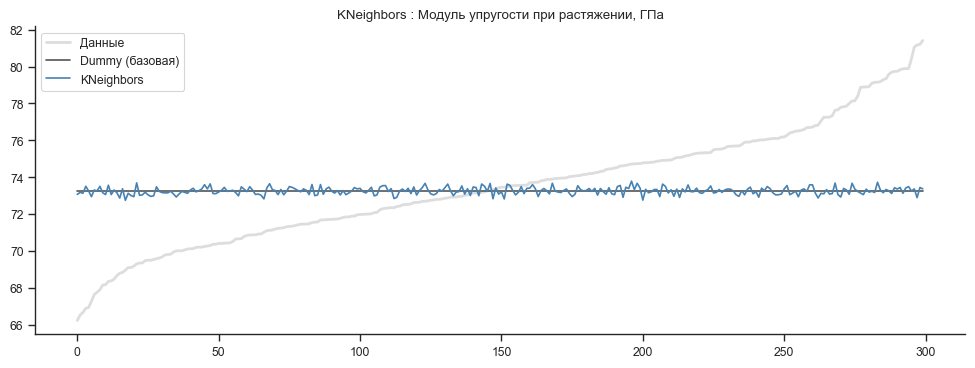

In [69]:
# визуализация качества лучшей модели на тестовых данных
X_ml_test_0, Y_ml_test_0 = X_ml_test, Y_ml_test[0]
X_ml_test_0, Y_ml_test_0 = project_sort_df(X_ml_test_0, Y_ml_test_0, 'Модуль упругости при растяжении, ГПа')
project_ml_plot(
    mod_ml[0]['prm']['fit'],
    project_ml_name_model(mod_ml[0]['prm']['stat_test'], 'MSE'),
    X_ml_test_0, Y_ml_test_0, Y_ml_label[0]
)

In [70]:
# вывод параметров
for i in mod_ml[0]['prm']['stat_test'].index:
    print(i + ':', mod_ml[0]['prm']['stat_test']['PARAM'][i])
    print('=========================')

Dummy: {}
Linear: {'Model__fit_intercept': True, 'Model__positive': True}
Lasso: {'Model__alpha': 0.1, 'Model__fit_intercept': True, 'Model__positive': True, 'Model__precompute': True, 'Model__selection': 'cyclic', 'Model__tol': 1e-08, 'Model__warm_start': True}
Ridge: {'Model__alpha': 1e-08, 'Model__fit_intercept': True, 'Model__positive': False, 'Model__solver': 'sparse_cg', 'Model__tol': 5}
SVR: {'Model__C': 1e-07, 'Model__degree': 1, 'Model__epsilon': 1e-06, 'Model__kernel': 'linear', 'Model__tol': 20}
KNeighbors: {'Model__leaf_size': 1, 'Model__metric': 'correlation', 'Model__n_neighbors': 200, 'Model__p': 1, 'Model__weights': 'uniform'}
DecisionTree: {'Model__ccp_alpha': 0.0, 'Model__criterion': 'squared_error', 'Model__max_depth': 1, 'Model__max_features': 'sqrt', 'Model__splitter': 'random'}
RandomForestRegressor: {'Model__ccp_alpha': 0.6, 'Model__criterion': 'squared_error', 'Model__max_depth': 3, 'Model__max_features': 'log2'}
GradientBoosting: {'Model__alpha': 0.8, 'Model__c

## 5.5. Модель: Прочность при растяжении, МПа

### 5.5.1. Подбор наилучшей модели с параметрами по умолчанию

In [71]:
# Прочность при растяжении, МПа
print(Y_ml_label[1])
print('═════════════════════════════════════════════')
projest_ml_fit_run(1)

Прочность при растяжении, МПа
═════════════════════════════════════════════
Model                    min(MSE)
Dummy                   -236584.90585075459
Linear                  -233188.25126020596
Lasso                   -233492.17421567137
Ridge                   -232567.21295311156
SVR                     -236396.3406515819
KNeighbors              -284503.6721322761
DecisionTree            -522991.04297949886
RandomForestRegressor   -246884.4135746981
GradientBoosting        -261451.3559307262
AdaBoost                -241048.88746895004


In [72]:
# вывод результата проверки моделей на учебных данных
mod_ml[1]['def']['stat_train'].loc[:, mod_ml_stat_columns!='PARAM']

MAE            MSE        RMSE      MAPE  \
Dummy                 -386.415672 -239318.393768 -489.201792 -0.169396   
Linear                -382.441383 -232715.142975 -482.405579 -0.166989   
Lasso                 -382.225548 -232976.036557 -482.675913 -0.167036   
Ridge                 -382.353743 -232726.088810 -482.416924 -0.166988   
SVR                   -385.716268 -238868.988002 -488.742251 -0.168402   
KNeighbors            -354.360586 -191806.331147 -437.956997 -0.153557   
DecisionTree            -0.000000      -0.000000   -0.000000 -0.000000   
RandomForestRegressor -151.763396  -36632.673045 -191.396638 -0.066207   
GradientBoosting      -272.047066 -116209.009438 -340.894426 -0.118713   
AdaBoost              -366.992473 -201292.694565 -448.656544 -0.160679   

                         MAX ERROR       R^2  
Dummy                 -1444.965533  0.000000  
Linear                -1345.557146  0.027592  
Lasso                 -1342.417920  0.026502  
Ridge                 -1346.086267  0.027546  
SVR                   -1428.131954  0.001878  
KNeighbors            -1234.266966  0.198531  
DecisionTree             -0.000000  1.000000  
RandomForestRegressor  -664.039088  0.846929  
GradientBoosting      -1129.118302  0.514417  
AdaBoost              -1080.734820  0.158892

In [73]:
# вывод результата проверки моделей на тестовых данных
mod_ml[1]['def']['stat_test'].loc[:, mod_ml_stat_columns!='PARAM']

MAE            MSE        RMSE      MAPE  \
Dummy                 -372.358736 -222958.372798 -472.184681 -0.168333   
Linear                -382.299623 -229395.777945 -478.952793 -0.173127   
Lasso                 -381.561588 -228665.723637 -478.190050 -0.172770   
Ridge                 -381.924932 -229014.016185 -478.554089 -0.172948   
SVR                   -371.326132 -222030.422324 -471.201042 -0.167256   
KNeighbors            -406.596069 -264486.528661 -514.282538 -0.182101   
DecisionTree          -558.212580 -489145.251860 -699.389199 -0.243980   
RandomForestRegressor -392.542977 -241071.076707 -490.989895 -0.177170   
GradientBoosting      -405.690109 -250998.889318 -500.997894 -0.182799   
AdaBoost              -391.283361 -237154.513467 -486.985127 -0.177387   

                         MAX ERROR       R^2  
Dummy                 -1410.698387 -0.012758  
Linear                -1353.786640 -0.041999  
Lasso                 -1362.052951 -0.038683  
Ridge                 -1352.328422 -0.040265  
SVR                   -1398.467375 -0.008543  
KNeighbors            -1439.734730 -0.201394  
DecisionTree          -1967.839967 -1.221876  
RandomForestRegressor -1503.460163 -0.095033  
GradientBoosting      -1407.300415 -0.140128  
AdaBoost              -1355.647641 -0.077242

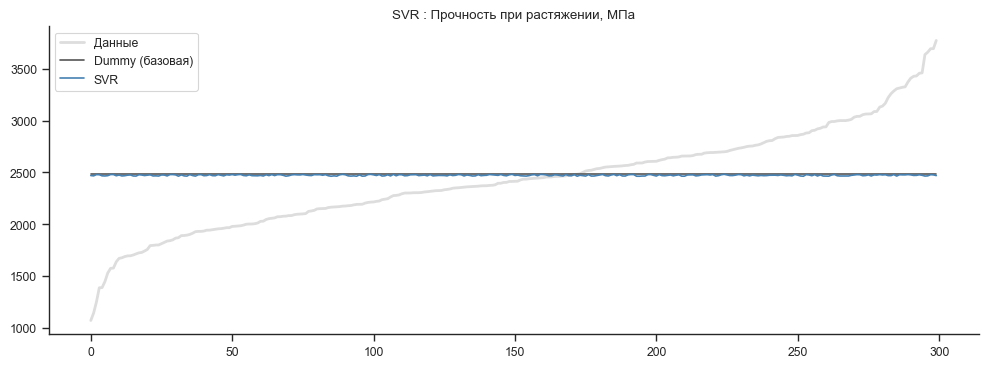

In [74]:
# визуализация качества модели на тестовых данных
X_ml_test_1, Y_ml_test_1 = X_ml_test, Y_ml_test[1]
X_ml_test_1, Y_ml_test_1 = project_sort_df(X_ml_test_1, Y_ml_test_1, 'Прочность при растяжении, МПа')
project_ml_plot(
    mod_ml[1]['def']['fit'],
    project_ml_name_model(mod_ml[1]['def']['stat_test'], 'MSE'),
    X_ml_test_1, Y_ml_test_1, Y_ml_label[1]
)

### 5.5.2. Подбор наилучшей модели с перебором гиперпараметров

In [75]:
# Прочность при растяжении, МПа
print(Y_ml_label[1])
print('═════════════════════════════════════════════')
projest_ml_fit_run(1, True)

Прочность при растяжении, МПа
═════════════════════════════════════════════
Model                    min(MSE)
Dummy                   -236584.90585075459
Linear                  -232646.83351817317
Lasso                   -231190.5765714696
Ridge                   -230786.42941759372
SVR                     -233689.3758016263
KNeighbors              -235914.5436542715
DecisionTree            -235345.0487562103
RandomForestRegressor   -234651.23590507038
GradientBoosting        -235421.97326390631
AdaBoost                -233034.5634986632


In [76]:
# вывод результата проверки моделей на учебных данных
mod_ml[1]['prm']['stat_train'].loc[:, mod_ml_stat_columns!='PARAM']

MAE           MSE          RMSE          MAPE  \
Dummy                 -3.864157e+02 -2.393184e+05 -4.892018e+02 -1.693960e-01   
Linear                -3.824414e+02 -2.327151e+05 -4.824056e+02 -1.669895e-01   
Lasso                 -3.828565e+02 -2.341262e+05 -4.838659e+02 -1.673501e-01   
Ridge                 -3.878892e+02 -2.391148e+05 -4.889937e+02 -1.693547e-01   
SVR                   -3.827898e+02 -2.351166e+05 -4.848882e+02 -1.674811e-01   
KNeighbors            -1.613215e-11 -2.402616e-21 -4.901649e-11 -7.142458e-15   
DecisionTree          -3.860163e+02 -2.391400e+05 -4.890194e+02 -1.692089e-01   
RandomForestRegressor -3.682036e+02 -2.144690e+05 -4.631080e+02 -1.609646e-01   
GradientBoosting      -3.803955e+02 -2.332672e+05 -4.829774e+02 -1.663481e-01   
AdaBoost              -3.724126e+02 -2.189107e+05 -4.678789e+02 -1.624951e-01   

                          MAX ERROR       R^2  
Dummy                 -1.444966e+03  0.000000  
Linear                -1.345557e+03  0.027592  
Lasso                 -1.339799e+03  0.021696  
Ridge                 -1.383594e+03  0.000851  
SVR                   -1.391250e+03  0.017558  
KNeighbors            -3.410605e-10  1.000000  
DecisionTree          -1.431667e+03  0.000745  
RandomForestRegressor -1.316560e+03  0.103834  
GradientBoosting      -1.428000e+03  0.025285  
AdaBoost              -1.338576e+03  0.085274

In [77]:
# вывод результата проверки моделей на тестовых данных
mod_ml[1]['prm']['stat_test'].loc[:, mod_ml_stat_columns!='PARAM']

MAE            MSE        RMSE      MAPE  \
Dummy                 -372.358736 -222958.372798 -472.184681 -0.168333   
Linear                -382.299623 -229395.777945 -478.952793 -0.173127   
Lasso                 -385.524825 -232881.817601 -482.578302 -0.174229   
Ridge                 -390.970732 -237654.675614 -487.498385 -0.175876   
SVR                   -376.097846 -224776.213894 -474.105699 -0.170108   
KNeighbors            -374.881034 -223486.880780 -472.743991 -0.169487   
DecisionTree          -372.716039 -223145.040037 -472.382303 -0.168458   
RandomForestRegressor -379.034853 -225989.253985 -475.383271 -0.171313   
GradientBoosting      -375.906627 -223915.721332 -473.197339 -0.169641   
AdaBoost              -383.319239 -228718.870160 -478.245617 -0.173546   

                         MAX ERROR       R^2  
Dummy                 -1410.698387 -0.012758  
Linear                -1353.786640 -0.041999  
Lasso                 -1388.287333 -0.057834  
Ridge                 -1362.993710 -0.079514  
SVR                   -1393.813831 -0.021015  
KNeighbors            -1397.671643 -0.015159  
DecisionTree          -1397.399421 -0.013606  
RandomForestRegressor -1415.395655 -0.026525  
GradientBoosting      -1408.255676 -0.017107  
AdaBoost              -1401.701250 -0.038924

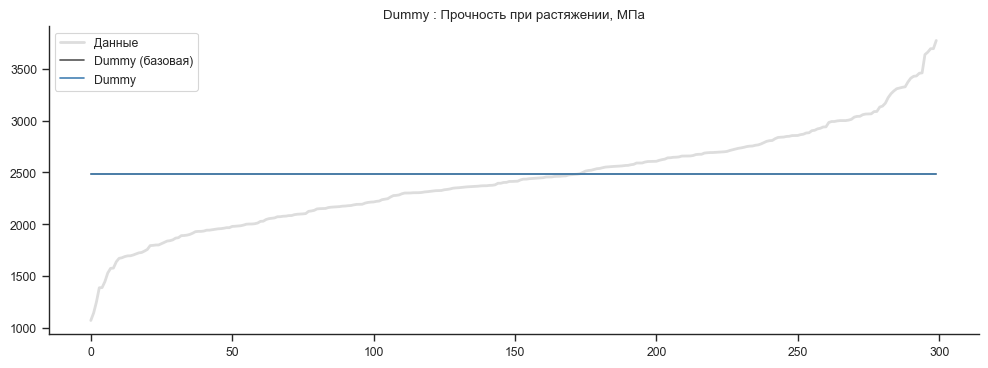

In [78]:
# визуализация качества модели на тестовых данных
X_ml_test_1, Y_ml_test_1 = X_ml_test, Y_ml_test[1]
X_ml_test_1, Y_ml_test_1 = project_sort_df(X_ml_test_1, Y_ml_test_1, 'Прочность при растяжении, МПа')
project_ml_plot(
    mod_ml[1]['prm']['fit'],
    project_ml_name_model(mod_ml[1]['prm']['stat_test'], 'MSE'),
    X_ml_test_1, Y_ml_test_1, Y_ml_label[1]
)

In [79]:
# вывод параметров
for i in mod_ml[1]['prm']['stat_test'].index:
    print(i + ':', mod_ml[1]['prm']['stat_test']['PARAM'][i])
    print('=========================')

Dummy: {}
Linear: {'Model__fit_intercept': False, 'Model__positive': False}
Lasso: {'Model__alpha': 0.1, 'Model__fit_intercept': True, 'Model__positive': False, 'Model__precompute': False, 'Model__selection': 'random', 'Model__tol': 10, 'Model__warm_start': True}
Ridge: {'Model__alpha': 5, 'Model__fit_intercept': True, 'Model__positive': False, 'Model__solver': 'saga', 'Model__tol': 1}
SVR: {'Model__C': 16, 'Model__degree': 1, 'Model__epsilon': 1, 'Model__kernel': 'poly', 'Model__tol': 5}
KNeighbors: {'Model__leaf_size': 1, 'Model__metric': 'correlation', 'Model__n_neighbors': 270, 'Model__p': 1, 'Model__weights': 'distance'}
DecisionTree: {'Model__ccp_alpha': 0.6, 'Model__criterion': 'squared_error', 'Model__max_depth': 1, 'Model__max_features': 'sqrt', 'Model__splitter': 'random'}
RandomForestRegressor: {'Model__ccp_alpha': 1.5, 'Model__criterion': 'friedman_mse', 'Model__max_depth': 3, 'Model__max_features': 'sqrt'}
GradientBoosting: {'Model__alpha': 0.6, 'Model__ccp_alpha': 0.0, 'M

## 5.6. Нейронная сеть: Соотношение матрицы-наполнителя

### 5.6.1. Генерация структуры данных для хранения результатов обучения

In [80]:
stat = pd.DataFrame({
    'Y_MIN': [],
    'Y_MEAN': [],
    'Y_MAX': [],
    'LOSS': [],
    'VAL_LOSS': [],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'MAPE': [],
    'MAX ERROR': [],
    'R^2': []
})

mod_nn = {
    'fit': {},
    'stat_test': stat.copy(),
    'stat_train': stat.copy()
}

### 5.6.2. Вспомогательные функции

In [81]:
# функция формирования статистики по обучению
def project_nn_stat(name, stat, Y, Y_pr, history=False):
    if name not in mod_nn[stat].index: mod_nn[stat].index.append(pd.Index([name]))
    mod_nn[stat].loc[name] = [
        Y.min().values[0],
        Y.mean().values[0],
        Y.max().values[0],
        history['loss'][-1] if history else '-',
        history['val_loss'][-1] if history else '-',
        -metrics.mean_absolute_error(Y, Y_pr),
        -metrics.mean_squared_error(Y, Y_pr),
        -pow(metrics.mean_squared_error(Y, Y_pr), 0.5),
        -metrics.mean_absolute_percentage_error(Y, Y_pr),
        -metrics.max_error(Y, Y_pr),
        metrics.r2_score(Y, Y_pr)
    ]

In [82]:
# функция визуализации ошибки обучения
def project_nn_plot_loss(history):
    plt.figure(figsize=(12, 4))
    plt.plot(history['loss'], label='LOSS (Ошибка обучения)')
    plt.plot(history['val_loss'], label='VAL_LOSS (Ошибка валидации)')
    plt.xticks(np.arange(0, len(history['loss']), 1.0))
    plt.xlabel('Эпохи обучения')
    plt.ylabel('Ошибка прогноза')
    plt.legend()
    plt.grid(True)

In [83]:
# функция визуализации качества модели
def project_nn_plot(model, name, X, Y):
    plt.figure(figsize=(12, 4))
    plt.plot(Y, color='#DDDDDD', label='Данные', linewidth=2)
    plt.plot([Y.mean().values[0]] * len(Y), color='#555555', label='Базовая модель')
    plt.plot(model.predict(X), color='#4682B4', label=name)
    plt.legend(loc='best')
    plt.title(name + ' : Соотношение матрицы-наполнителя')
    #plt.ylim([2400, 2600])
    plt.show()

### 5.6.3. Базовая модель

In [84]:
# регистрации базовой модели
Y_nn_train_base = [Y_nn_train.mean().values[0]] * len(Y_nn_train)
Y_nn_test_base = [Y_nn_test.mean().values[0]] * len(Y_nn_test)
project_nn_stat('Базовая модель', 'stat_test', Y_nn_test, Y_nn_test_base)
project_nn_stat('Базовая модель', 'stat_train', Y_nn_train, Y_nn_train_base)

### 5.6.4. Сортировка относительно целевого признака

In [85]:
X_nn_train_s, Y_nn_train_s = project_sort_df(X_nn_train, Y_nn_train, 'Соотношение матрица-наполнитель')
X_nn_test_s, Y_nn_test_s = project_sort_df(X_nn_test, Y_nn_test, 'Соотношение матрица-наполнитель')

### 5.6.5. Модель №1

CPU times: total: 3.16 s
Wall time: 3.16 s


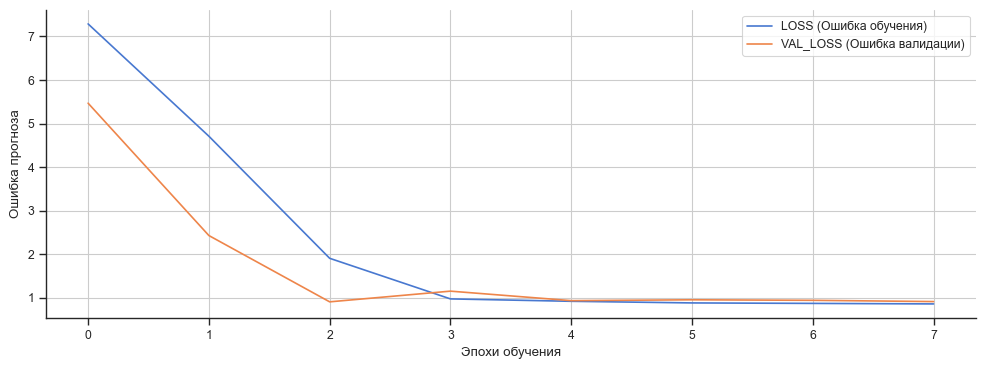

In [102]:
%%time
nn_name = 'Нейронная сеть'
nn = Pipeline([
    ('Transform', ColumnTransformer([
        ('scaler', MinMaxScaler(), X_nn_label_dig),
        ('category', OneHotEncoder(), X_nn_label_cat)
    ])),
    ('Estimator', KerasRegressor(
        keras.Sequential([
            layers.Input(shape=(13,), name='in'),
            
            layers.Dense(13, activation='relu'),
            #layers.Dropout(0.5),
            layers.Dense(13, activation='relu'),
            #layers.Dropout(0.5),
            layers.Dense(13, activation='relu'),
            #layers.Dropout(0.5),
            layers.Dense(13, activation='relu'),
            #layers.Dropout(0.5),
            
#             layers.Dense(169, activation='relu', name='dense_1'),
#             layers.Dropout(0.5),
#             layers.Dense(169, activation='relu', name='dense_2'),
#             layers.Dropout(0.5),
#             layers.Dense(169, activation='relu', name='dense_3'),
#             layers.Dropout(0.5),
            
            
            #layers.Dropout(0.5),
#             layers.Dense(13, activation='relu'), layers.Dropout(0.5),
#             layers.Dense(13, activation='relu'), layers.Dropout(0.5),
#             layers.Dense(13, activation='relu'), layers.Dropout(0.5),
#             layers.Dense(13, activation='relu'), layers.Dropout(0.5),
#             layers.Dense(13, activation='relu'), layers.Dropout(0.5),
#             layers.Dense(13, activation='relu'), layers.Dropout(0.5),
#             layers.Dense(13, activation='relu'), layers.Dropout(0.5),
#             layers.Dense(13, activation='relu'), layers.Dropout(0.5),
#             layers.Dense(13, activation='relu'), layers.Dropout(0.5),
#             layers.Dense(13, activation='relu'), layers.Dropout(0.5),
#             layers.Dense(13, activation='relu'), layers.Dropout(0.5),
#             layers.Dense(13, activation='relu'), layers.Dropout(1),
#             layers.Dense(13, activation='relu'), layers.Dropout(1),
            
            layers.Dense(1, activation='relu', name='out')
        ]),
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.MeanSquaredError(),
        validation_split=0.1,
        verbose=False,
        epochs=100,
        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    ))
]).fit(X_nn_train, Y_nn_train.values)

history = nn.named_steps['Estimator'].model.history
mod_nn['fit'][nn_name] = {'history': history, 'model': nn}
project_nn_plot_loss(history.history)
project_nn_stat(nn_name, 'stat_test', Y_nn_test, nn.predict(X_nn_test), history.history)
project_nn_stat(nn_name, 'stat_train', Y_nn_train, nn.predict(X_nn_train), history.history)

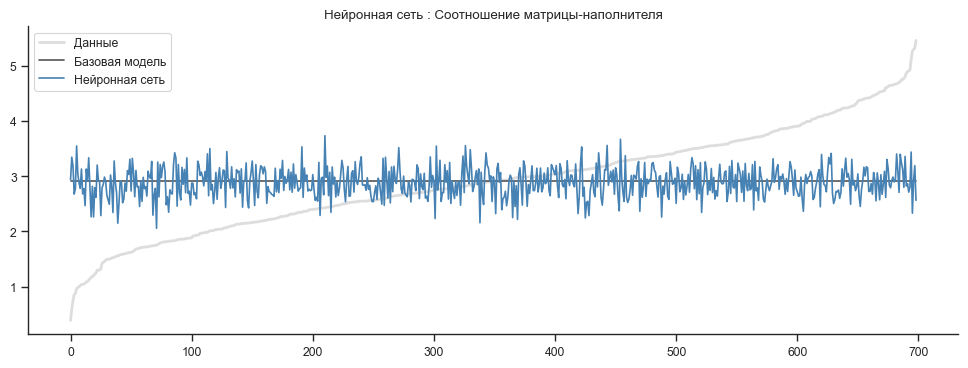

Y_MIN    Y_MEAN     Y_MAX      LOSS  VAL_LOSS       MAE  \
Базовая модель  0.389403  2.914985  5.455566         -         - -0.723067   
Нейронная сеть  0.389403  2.914985  5.455566  0.856962  0.910833 -0.749079   

                     MSE      RMSE      MAPE  MAX ERROR       R^2  
Базовая модель -0.807600 -0.898666 -0.313261  -2.540581  0.000000  
Нейронная сеть -0.858829 -0.926730 -0.318937  -2.928592 -0.063433

In [103]:
project_nn_plot(mod_nn['fit']['Нейронная сеть']['model'], 'Нейронная сеть', X_nn_train_s, Y_nn_train_s)
mod_nn['stat_train']

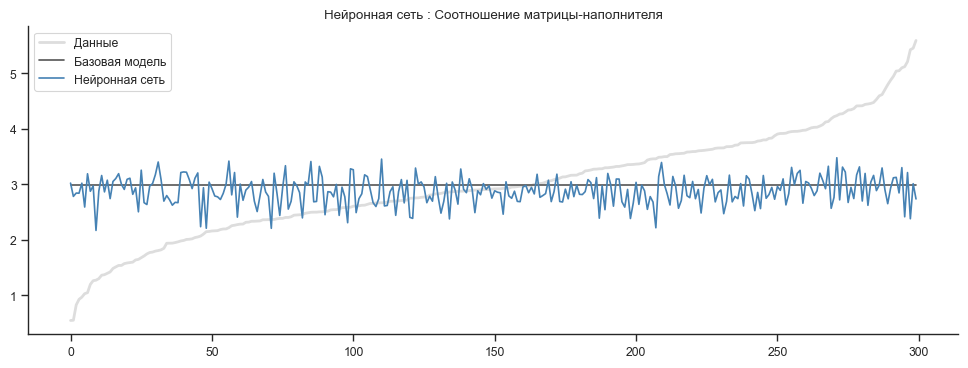

Y_MIN    Y_MEAN     Y_MAX      LOSS  VAL_LOSS       MAE  \
Базовая модель  0.547391  2.988726  5.591742         -         - -0.734309   
Нейронная сеть  0.547391  2.988726  5.591742  0.856962  0.910833 -0.753422   

                     MSE      RMSE      MAPE  MAX ERROR       R^2  
Базовая модель -0.862368 -0.928638 -0.320546  -2.603016  0.000000  
Нейронная сеть -0.919116 -0.958705 -0.318163  -3.045294 -0.065805

In [104]:
project_nn_plot(mod_nn['fit']['Нейронная сеть']['model'], 'Нейронная сеть', X_nn_test_s, Y_nn_test_s)
mod_nn['stat_test']

In [105]:
mod_nn['fit']['Нейронная сеть']['model'].named_steps['Estimator'].model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 13)                  │             182 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 13)                  │             182 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 13)                  │             182 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 13)                  │             182 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out (Dense)                          │ (None, 1)                   │              14 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,228 (8.71 KB)

 Trainable params: 742 (2.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,486 (5.81 KB)

# 6. Сохранение моделей

## 6.1. Функция определения лучшей модели, сохранения и загрузки

In [92]:
def best_model_ml(y, only_prm = True):
    t_err = 'MSE'
    err_def = mod_ml[y]['def']['stat_test']
    err_prm = mod_ml[y]['prm']['stat_test']
    best_score = [
        err_def[err_def[t_err] == err_def[t_err].max()][t_err].values[0],
        err_prm[err_prm[t_err] == err_prm[t_err].max()][t_err].values[0],
    ]

    best_index = best_score.index(max(best_score))
    if (only_prm): best_index = 1; # выбор только из набора с подбором параметров
        
    if (best_index == 0):
        print('ТИП ПОИСКА: Параметры по умолчанию')
        err_def = err_def[err_def[t_err] == err_def[t_err].max()]
        name = err_def.index[0]
        r2 = err_def['R^2'].values[0]
        model = mod_ml[y]['def']['fit'][name].best_estimator_
    else:
        print('ТИП ПОИСКА: Подбор параметров')
        err_prm = err_prm[err_prm[t_err] == err_prm[t_err].max()]
        name = err_prm.index[0]
        r2 = err_prm['R^2'].values[0]
        model = mod_ml[y]['prm']['fit'][name].best_estimator_
        
    print('ЛУЧШАЯ МОДЕЛЬ:', name)
    print(t_err + ':', best_score[best_index])
    print('R^2:', r2)
    
    return name, model


def save_model(filename, model):
    file = open(filename, 'wb')
    pickle.dump(model, file)
    file.close()


def load_model(filename):
    file = open(filename, 'rb')
    model = pickle.load(file)
    file.close()
    return model

## 6.2. Модуль упругости при растяжении, ГПа

In [93]:
# Модуль упругости при растяжении, ГПа
print('ПРИЗНАК: Модуль упругости при растяжении, ГПа')
name, model_for_save = best_model_ml(0)

# --->
save_model('model/M1.pkl', model_for_save)

# >---
test = load_model('model/M1.pkl')

# тест
X_test_model = X_ml_test.sample(1)
test

ПРИЗНАК: Модуль упругости при растяжении, ГПа
ТИП ПОИСКА: Подбор параметров
ЛУЧШАЯ МОДЕЛЬ: KNeighbors
MSE: -9.477642495005885
R^2: 0.0019888175929341223


Pipeline(steps=[('Transform',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['Соотношение '
                                                   'матрица-наполнитель',
                                                   'Плотность, кг/м3',
                                                   'Модуль упругости, ГПа',
                                                   'Количество отвердителя, '
                                                   'м.%',
                                                   'Содержание эпоксидных '
                                                   'групп, %_2',
                                                   'Потребление смолы, г/м2',
                                                   'Шаг нашивки',
                                                   'Плотность нашивки']),
                                                 ('category', OneHotEncoder(),
                                                  ['Угол нашивки, град'])])),
                ('Model',
                 KNeighborsRegressor(leaf_size=1, metric='correlation',
                                     n_neighbors=200, p=1))])

## 6.3. Прочность при растяжении, МПа

In [94]:
# Прочность при растяжении, МПа
print('ПРИЗНАК: Прочность при растяжении, МПа')
name, model_for_save = best_model_ml(1)

# --->
save_model('model/M2.pkl', model_for_save)

# >---
test = load_model('model/M2.pkl')

# тест
X_test_model = X_ml_test.sample(1)
test

ПРИЗНАК: Прочность при растяжении, МПа
ТИП ПОИСКА: Подбор параметров
ЛУЧШАЯ МОДЕЛЬ: Dummy
MSE: -222958.3727979255
R^2: -0.0127580460566592


Pipeline(steps=[('Transform',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['Соотношение '
                                                   'матрица-наполнитель',
                                                   'Плотность, кг/м3',
                                                   'Модуль упругости, ГПа',
                                                   'Количество отвердителя, '
                                                   'м.%',
                                                   'Содержание эпоксидных '
                                                   'групп, %_2',
                                                   'Потребление смолы, г/м2',
                                                   'Шаг нашивки',
                                                   'Плотность нашивки']),
                                                 ('category', OneHotEncoder(),
                                                  ['Угол нашивки, град'])])),
                ('Model', DummyRegressor())])

## 6.4. Соотношение матрицы-наполнителя

In [106]:
# Соотношение матрицы-наполнителя
print('ПРИЗНАК: Соотношение матрица-наполнитель')

# определение лучшей модели
t_err = 'MSE'
df_temp = mod_nn['stat_test'].drop(index=['Базовая модель'])
best = df_temp[df_temp[t_err] == df_temp[t_err].max()].index[0]
model = mod_nn['fit'][best]['model']
print('ЛУЧШАЯ МОДЕЛЬ:', best)
print(t_err + ':', df_temp.loc[best][t_err])
print('R^2:', df_temp.loc[best]['R^2'])

# --->
save_model('model/M3.pkl', model)

# >---
model = load_model('model/M3.pkl')

# тест
model

ПРИЗНАК: Соотношение матрица-наполнитель
ЛУЧШАЯ МОДЕЛЬ: Нейронная сеть
MSE: -0.9191158776818252
R^2: -0.06580490534284733


Pipeline(steps=[('Transform',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['Плотность, кг/м3',
                                                   'Модуль упругости, ГПа',
                                                   'Количество отвердителя, '
                                                   'м.%',
                                                   'Содержание эпоксидных '
                                                   'групп, %_2',
                                                   'Температура вспышки, С_2',
                                                   'Поверхностная плотность, '
                                                   'г/м2',
                                                   'Модуль упругости при '
                                                   'растяжении, ГПа',
                                                   'Прочность при растяжении, '
                                                   'МПа',
                                                   'Потребление смолы, г/м2',
                                                   'Шаг нашивк...
                ('Estimator',
                 KerasRegressor(callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x000001B3B4B3BD90>], epochs=100, loss=<keras.src.losses.losses.MeanSquaredError object at 0x000001B3B3A4A350>, model=<Sequential name=sequential_3, built=True>, optimizer=<keras.src.optimizers.adam.Adam object at 0x000001B3B3A49150>, validation_split=0.1, verbose=False))])

# 7. Тестовые данные по моделям